## ТЕМА

# Импорт библиотек

In [ ]:
#pip install ydata_profiling

In [ ]:
#pip install dash

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt
import itertools
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import scipy
import sklearn

In [ ]:
from scipy.stats import norm, shapiro, kstest, chi2_contingency
from scipy import stats

In [ ]:
from sklearn import svm

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NeighborhoodComponentsAnalysis

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import RFECV, SequentialFeatureSelector

In [ ]:
import plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px
import dash
from dash import Dash, dcc, html, Input, Output

In [ ]:
from imblearn.under_sampling import TomekLinks

In [ ]:
def conf_matrix(fact, pred, labels):
    conf_test = confusion_matrix(fact, pred, normalize='true')
    #classes = fact.unique().astype(str)
    fig = px.imshow(
        conf_test,
        text_auto='.2f',
        color_continuous_scale='gray',
    labels = dict(x = 'Predicted', y = 'Actual'), x = labels, y = labels)

    fig.show()

In [ ]:
sns.set_theme(style="whitegrid", palette=sns.hls_palette(h=.5))

# Описание набора данных

Данные включают в себя информацию об активности отдельных пользователей приложения Waze (как в целом, так и за определенный месяц), представленную следующими признаками.

Целочисленные:
1. `ID` - уникальный номер пользователя.
2. `sessions` - количество сессий в приложении, то есть количество входов в него за месяц
3. `drives` - количество поездок на расстояние не менее 1 км.
4. `n_days_after_onboarding` - количество дней, прошедшее с момента регистрации пользователя в приложении.
5. `total_navigations_fav1` - Общее количество переходов с момента перехода в любимое место пользователя 1.
6. `total_navigations_fav2` - Общее количество переходов с момента перехода в любимое место пользователя 2.
7. `activity_days` - Количество дней, в течение которых пользователь открывает приложение в течение месяца.
8. `driving_days` - Количество дней, в течение которых пользователь проезжает (не менее 1 км) в течение месяца.

Вещественные:
1. `total_sessions` - оценка общего количества сеансов с момента подключения пользователя.
2. `duration_minutes_drives` - суммарная/общая продолжительность поездок пользователя за месяц в минутах.
3. `driven_km_drives` - суммарное количество километров, проеханное пользователем за месяц.

Строковый тип:
1. `device` - марка телефона
2. `label` - бинарная целевая переменная. Принимает значения: “retained”, если пользователь продолжает пользоваться приложением, или “churned”, если пользователь ушел к приложению-конкуренту.


Цель: предсказать отток пользователей из приложения.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/waze_dataset.csv')
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


# Предобработка данных

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


In [ ]:
df.columns

Index(['ID', 'label', 'sessions', 'drives', 'total_sessions',
       'n_days_after_onboarding', 'total_navigations_fav1',
       'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives',
       'activity_days', 'driving_days', 'device'],
      dtype='object')

In [ ]:
df.isna().sum()

,0
ID,0
label,700
sessions,0
drives,0
total_sessions,0
n_days_after_onboarding,0
total_navigations_fav1,0
total_navigations_fav2,0
driven_km_drives,0
duration_minutes_drives,0


In [ ]:
df.duplicated().sum()

0

In [ ]:
for i in df.columns:
    print(i, df[i].nunique())

ID 14999
label 2
sessions 469
drives 401
total_sessions 14999
n_days_after_onboarding 3441
total_navigations_fav1 730
total_navigations_fav2 287
driven_km_drives 14999
duration_minutes_drives 14999
activity_days 32
driving_days 31
device 2


In [ ]:
df = df[~df.label.isna()] #0,01%

## Обработка выбросов

In [ ]:
###Попвтка добавить новые количественные признаки не привела к успеху. Причины: рост числа выбросов, мультиколлинеарность факторов
#df['km_per_drive'] = df['driven_km_drives'] / df['drives'] #средняя расстояние 1 поездки
#df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days'] #средняя расстояние за день
#df['minutes_per_drives'] = df['duration_minutes_drives'] / df['drives'] #средняя продолжительность 1 поездки
#df['minutes_per_driving_day'] = df['duration_minutes_drives'] / df['driving_days'] #средняя продолжительность поездок в течение 1 дня

In [ ]:
#делим признаки на количественные и номинальные/категориальные
num = ['sessions',
       'drives',
       'total_sessions',
       'n_days_after_onboarding',
       'total_navigations_fav1',
       'total_navigations_fav2',
       'driven_km_drives',
       'duration_minutes_drives',
       'activity_days',
       'driving_days']

cat = ['device']

columns = num + cat

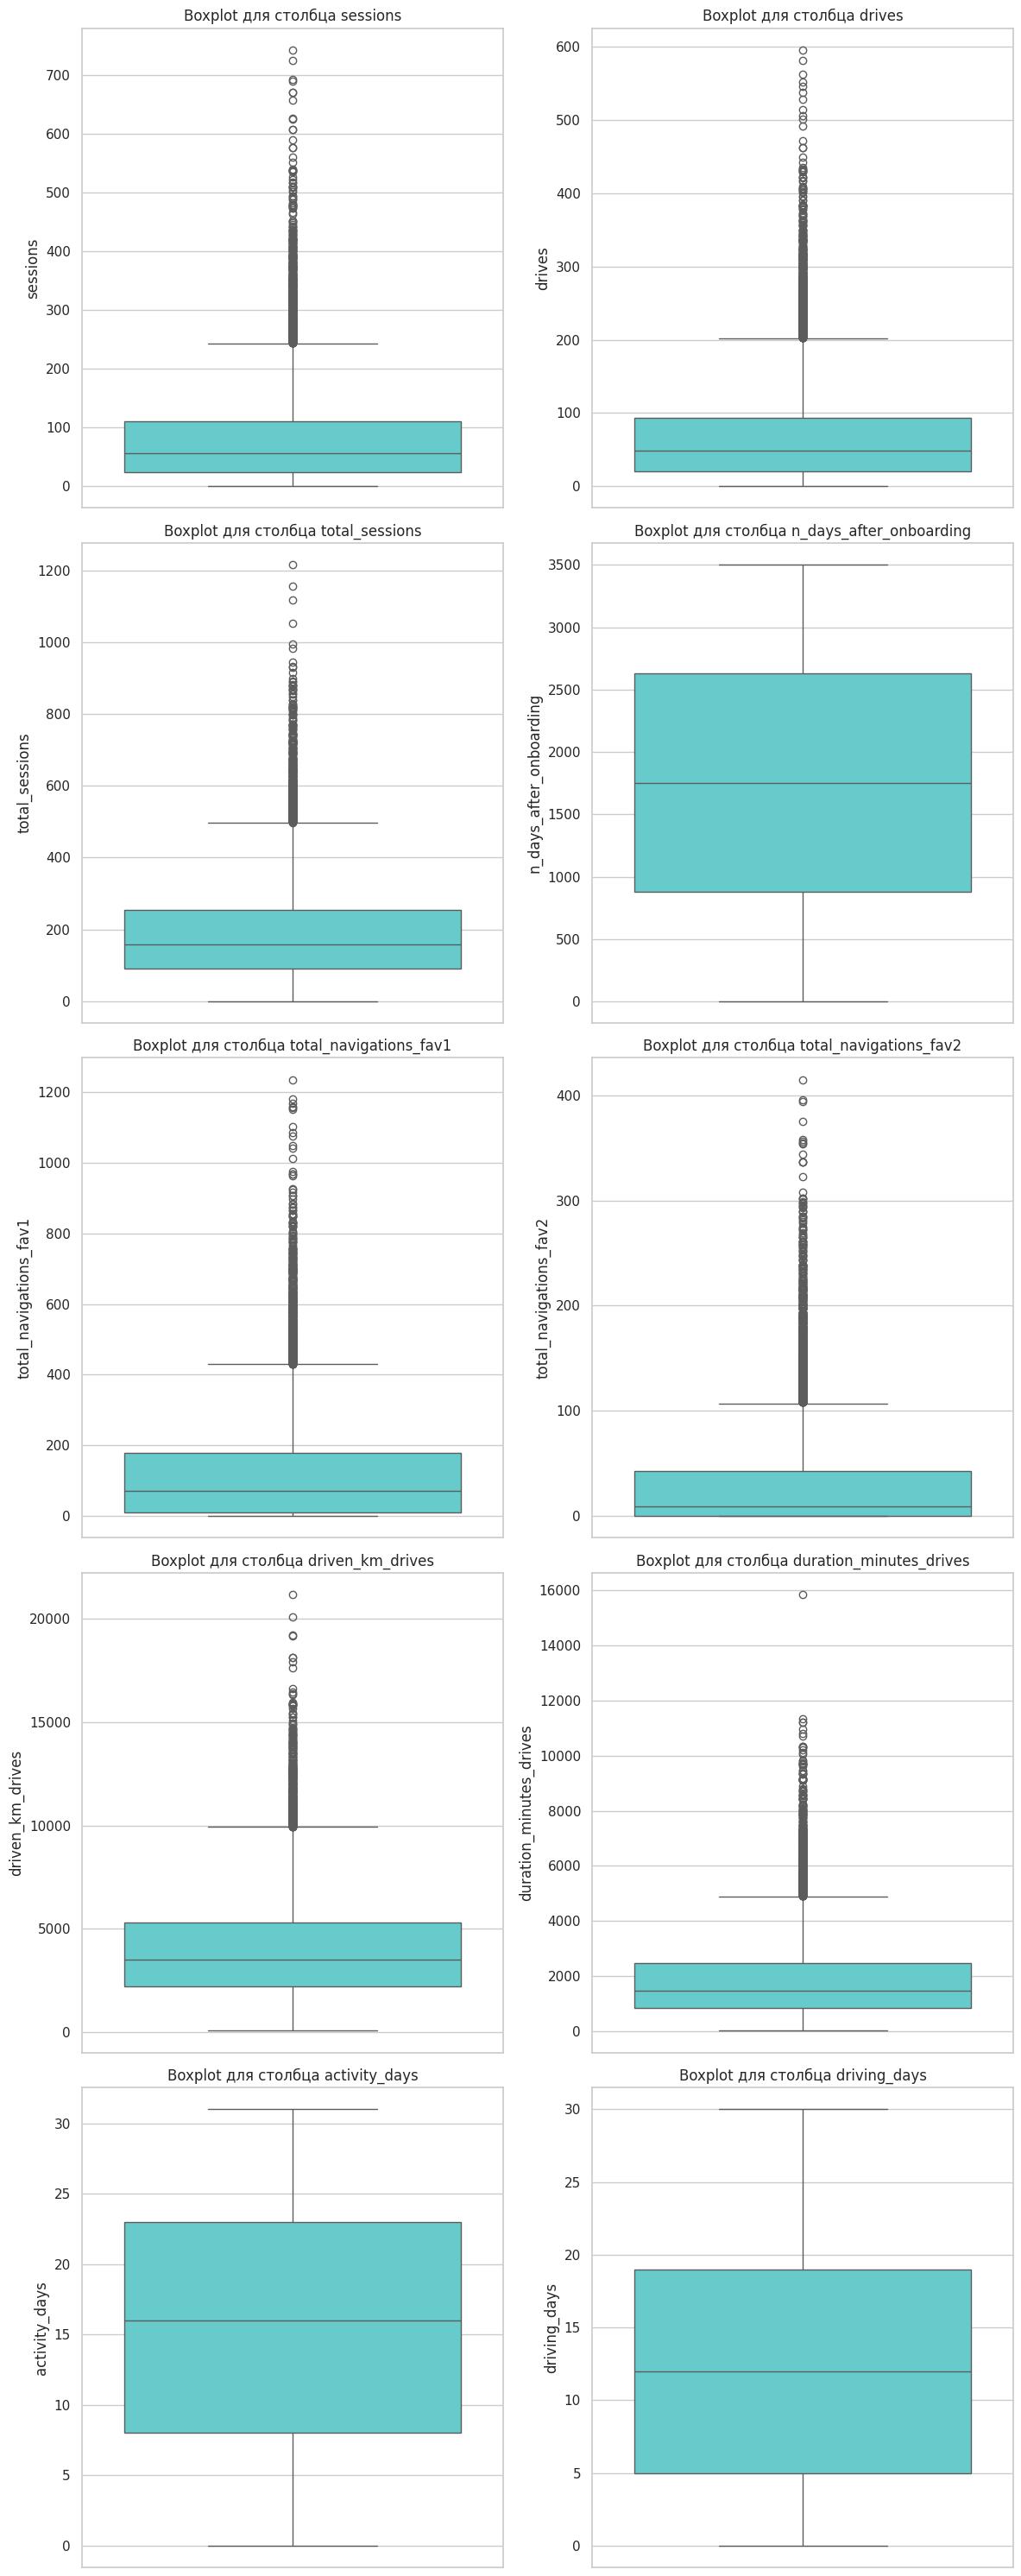

In [ ]:
num_plots = len(num)
num_rows = (num_plots + 1) // 2
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))
axes = axes.ravel()

for i, col in enumerate(num):
    sns.boxplot(y=df[col], ax=axes[i]) #
    axes[i].set_title(f'Boxplot для столбца {col}')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

In [ ]:
columns_with_outliers = ['sessions',
                         'drives',
                         'total_sessions',
                         'total_navigations_fav1',
                         'total_navigations_fav2',
                         'driven_km_drives',
                         'duration_minutes_drives']

### Удаление по IQR

In [ ]:
df_IQR = df.copy()
for col in columns_with_outliers:
    Q1 = df_IQR[col].quantile(0.25)
    Q3 = df_IQR[col].quantile(0.75)
    IQR = Q3 - Q1
    df_IQR = df_IQR[(df_IQR[col] > (Q1-1.5*IQR)) & (df_IQR[col] < (Q3+1.5*IQR))]

In [ ]:
len(df_IQR)

10710

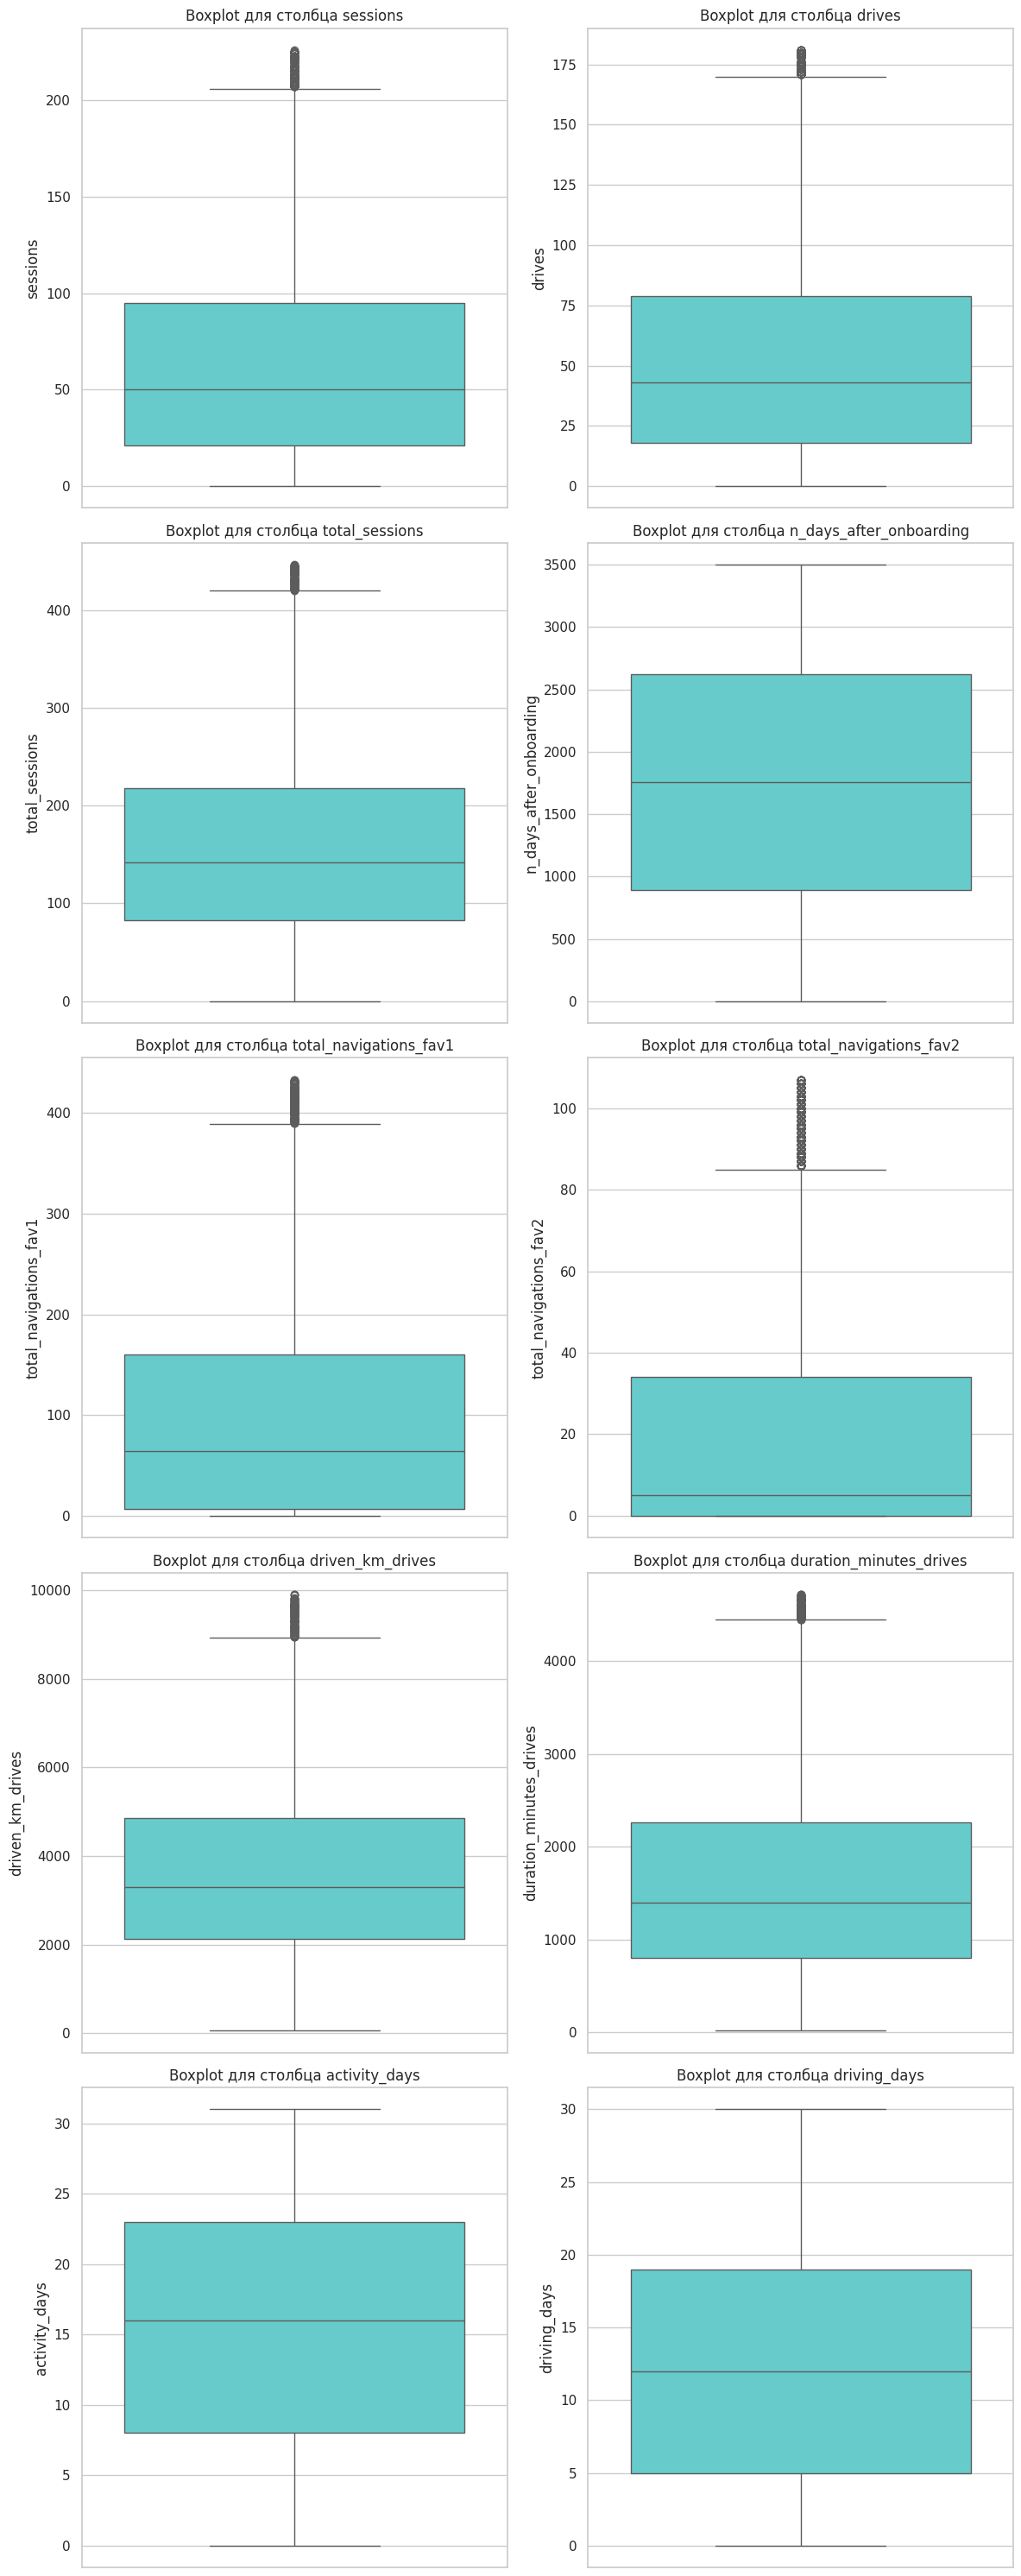

In [ ]:
num_plots = len(num)
num_rows = (num_plots + 1) // 2
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))
axes = axes.ravel()

for i, col in enumerate(num):
    sns.boxplot(y=df_IQR[col], ax=axes[i])
    axes[i].set_title(f'Boxplot для столбца {col}')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

### Удаление по std

In [ ]:
df_3s = df.copy()
for col in columns_with_outliers:
    z = np.abs(stats.zscore(df_3s[col]))
    df_3s = df_3s[z < 3]

In [ ]:
print(len(df_3s), 100 - len(df_3s) / len(df) * 100)

12665 11.427372543534503


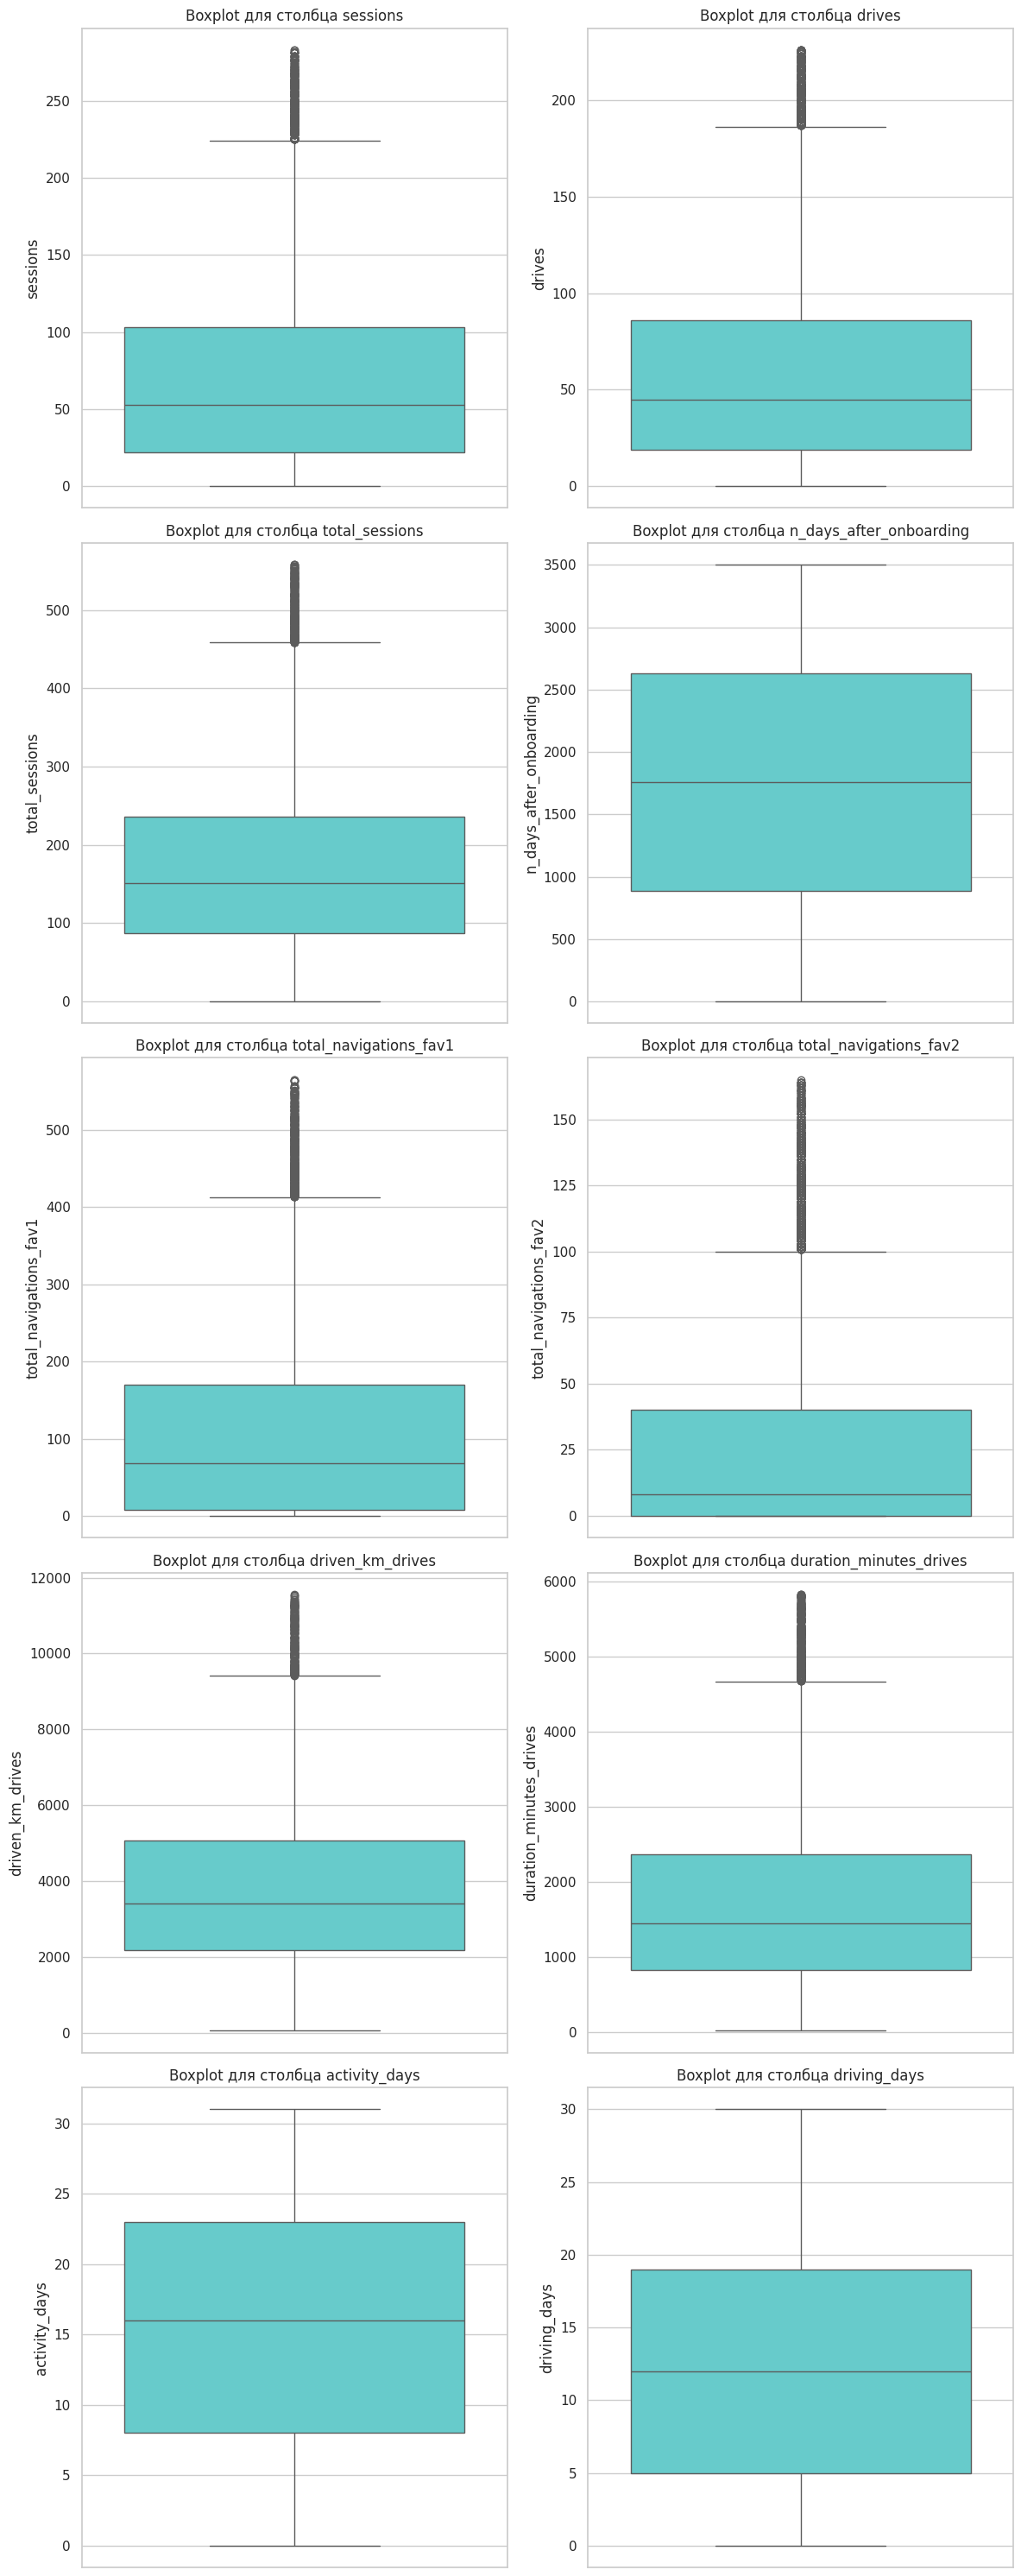

In [ ]:
num_plots = len(num)
num_rows = (num_plots + 1) // 2
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))
axes = axes.ravel()

for i, col in enumerate(num):
    sns.boxplot(y=df_3s[col], ax=axes[i]) #
    axes[i].set_title(f'Boxplot для столбца {col}')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

### Замена значений

In [ ]:
for col in columns_with_outliers:
    print(col, df[col].quantile(0.95))

sessions 243.0
drives 200.0
total_sessions 455.4394923899998
total_navigations_fav1 422.0
total_navigations_fav2 124.0
driven_km_drives 8898.716274999999
duration_minutes_drives 4668.180091799999


In [ ]:
df_q95 = df.copy()
for col in columns_with_outliers:
    Q95 = df_q95[col].quantile(0.95)
    df_q95 = df_q95[df_q95[col] < Q95]

In [ ]:
len(df_q95)

9947

In [ ]:
df_q95 = df.copy()
for col in columns_with_outliers:
    Q95 = df_q95[col].quantile(0.95)
    df_q95.loc[df_q95[col] > Q95, col] = Q95

In [ ]:
len(df_q95)

14299

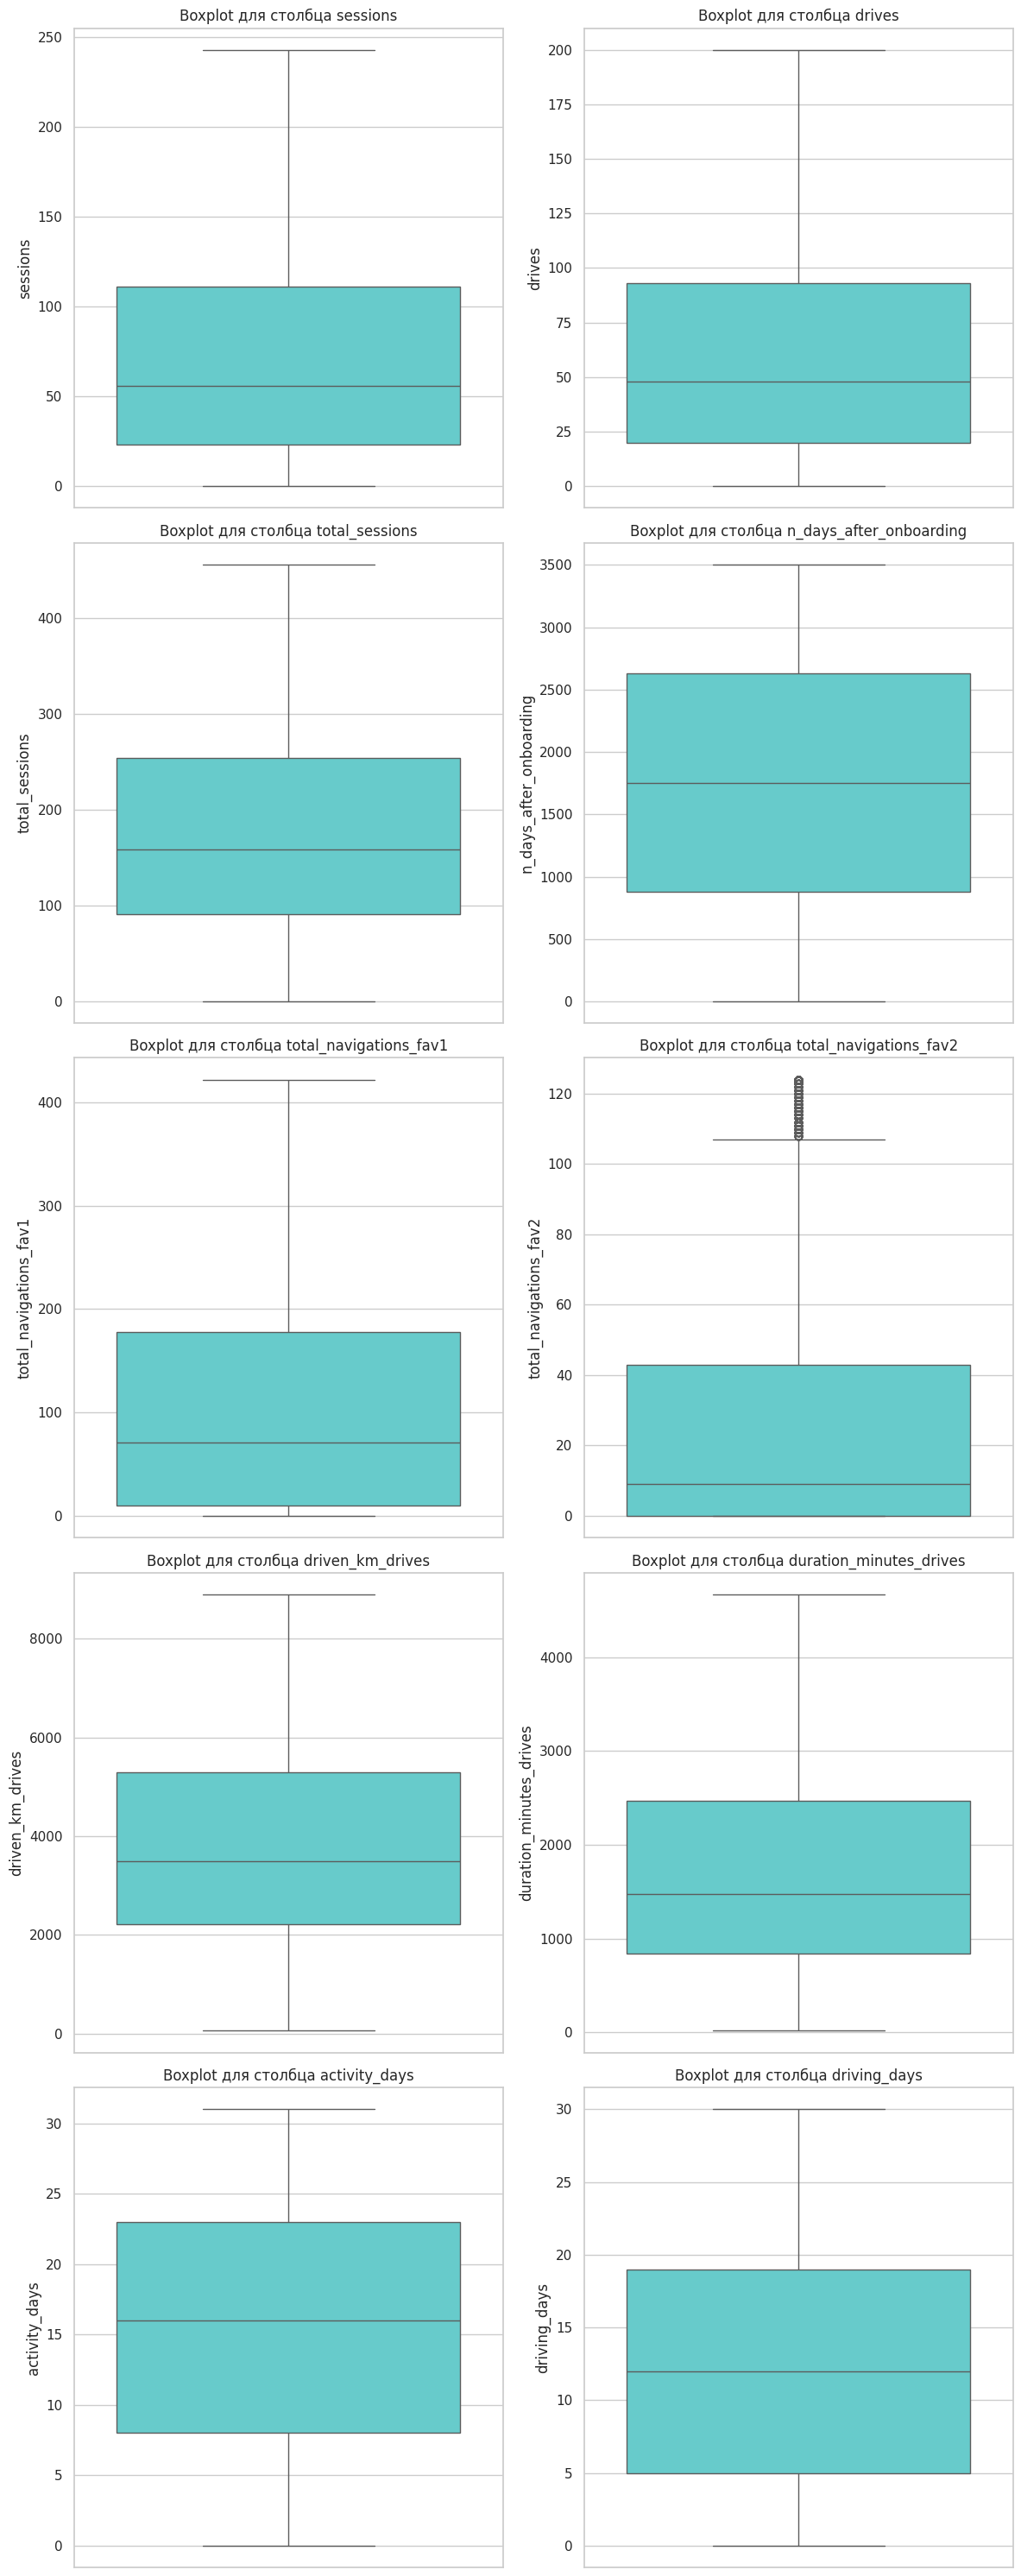

In [ ]:
num_plots = len(num)
num_rows = (num_plots + 1) // 2
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))
axes = axes.ravel()

for i, col in enumerate(num):
    sns.boxplot(y=df_q95[col], ax=axes[i]) #
    axes[i].set_title(f'Boxplot для столбца {col}')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

In [ ]:
df = df_q95.copy()

# Анализ количественных признаков

In [ ]:
df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,7503.573117,76.539688,63.964683,183.717304,1751.822505,114.562767,27.187216,3944.558631,1792.911210,15.544653,12.182530
std,4331.207621,67.243178,55.127927,118.720520,1008.663834,124.378550,36.715302,2218.358258,1224.329759,9.016088,7.833835
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000
50%,7504.000000,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000
75%,11257.500000,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000
max,14998.000000,243.000000,200.000000,455.439492,3500.000000,422.000000,124.000000,8898.716275,4668.180092,31.000000,30.000000


In [ ]:
app = Dash(__name__)

app.layout = html.Div([
    html.P("Признак:"),
    dcc.Dropdown(num, 'sessions', id='dropdown_value'),
    dcc.Graph(id="graph"),
])

@app.callback(
    Output("graph", "figure"),
    Input("dropdown_value", "value"))

def display_distplot(dropdown_value):
    quantile = stats.probplot(df[dropdown_value].values, dist='lognorm', sparams=(1))
    x = quantile[0][0]
    y = quantile[0][1]
    line_x = np.array([x[0], x[-1]])
    line_y = quantile[1][1] + quantile[1][0] * line_x

    fig = go.Figure()
    fig.add_scatter(x=x, y=y, mode='markers', name='Данные')
    fig.add_scatter(x=line_x, y=line_y, mode='lines', name='Квантиль')

    return fig
app.run_server(debug=True,port=8052)

<IPython.core.display.Javascript object>

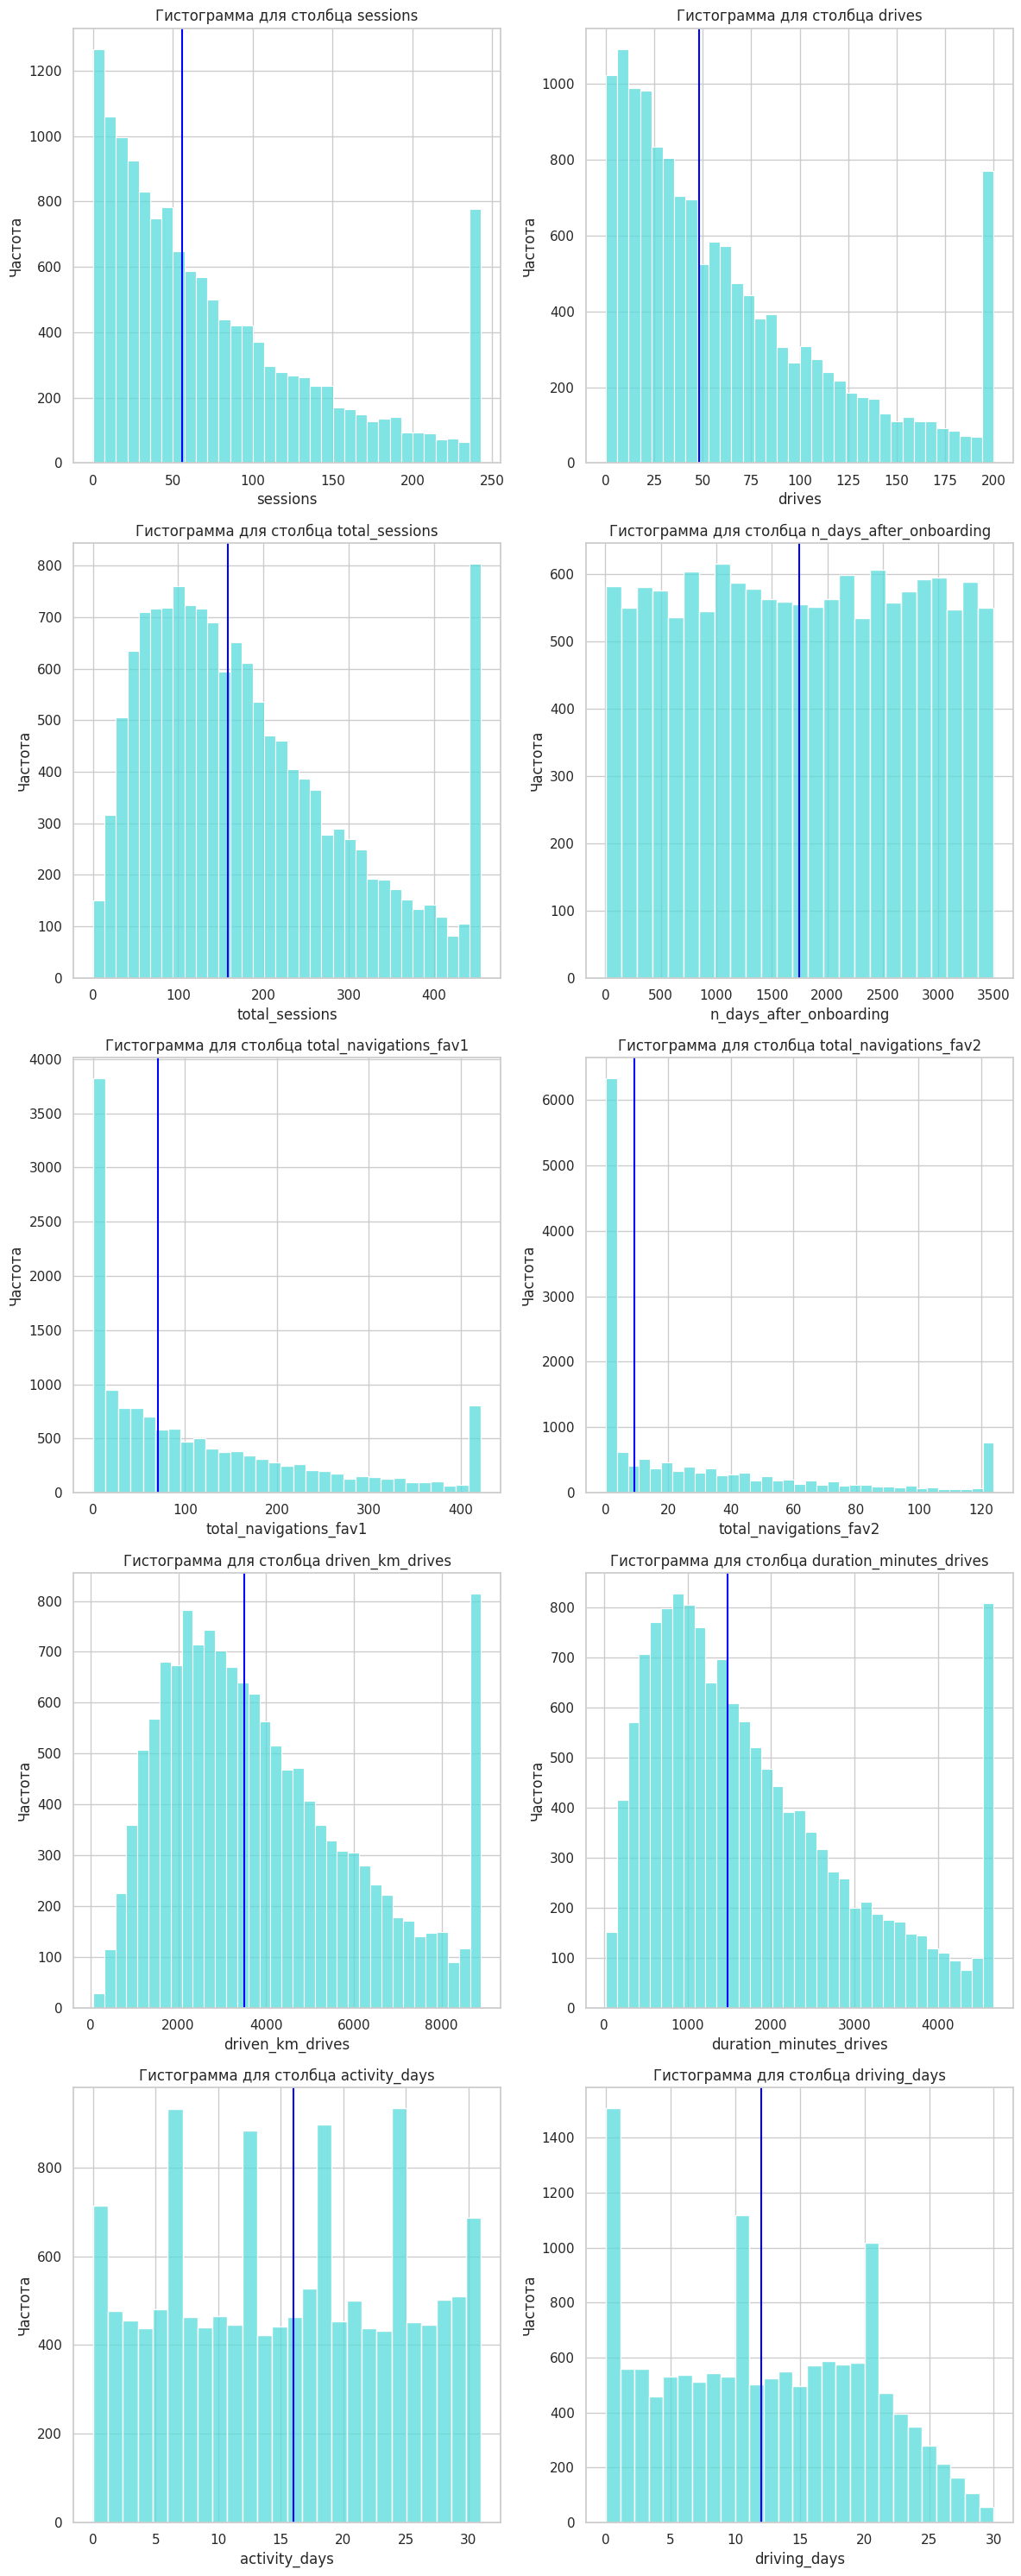

In [ ]:
num_plots = len(num)
num_rows = (num_plots + 1) // 2
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))
axes = axes.ravel()

for i, col in enumerate(num):
    sns.histplot(df[col], ax=axes[i])
    axes[i].axvline(df[col].median(), color='b', label='Медиана')
    axes[i].set_title(f'Гистограмма для столбца {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

Очевидно, что переменные не имеют нормального распределения

H0: нормальное распределение

In [ ]:
{i: kstest(df[i].values, 'norm').pvalue for i in num}

{'sessions': 0.0,
 'drives': 0.0,
 'total_sessions': 0.0,
 'n_days_after_onboarding': 0.0,
 'total_navigations_fav1': 0.0,
 'total_navigations_fav2': 0.0,
 'driven_km_drives': 0.0,
 'duration_minutes_drives': 0.0,
 'activity_days': 0.0,
 'driving_days': 0.0}

p < 0,05 , отвергаем

- r - Спирмена или t-Кенделла - если хотя бы одна из двух переменных, между которыми изучается связь, представлена в порядковой шкале или имеет распределение отличное от нормального.

Для всех вышеуказанных тестов нулевая гипотеза $H_0$ утверждает, что связи в данных нет.

In [ ]:
correlation_spearman = df[num].corr(method = 'spearman').round(2)

In [ ]:
fig = px.imshow(correlation_spearman, text_auto=True, color_continuous_scale='ice')
fig.show()

In [ ]:
correlation_kendall = df[num].corr(method = 'kendall').round(2)

In [ ]:
fig = px.imshow(correlation_kendall, text_auto=True, color_continuous_scale='ice')
fig.show()

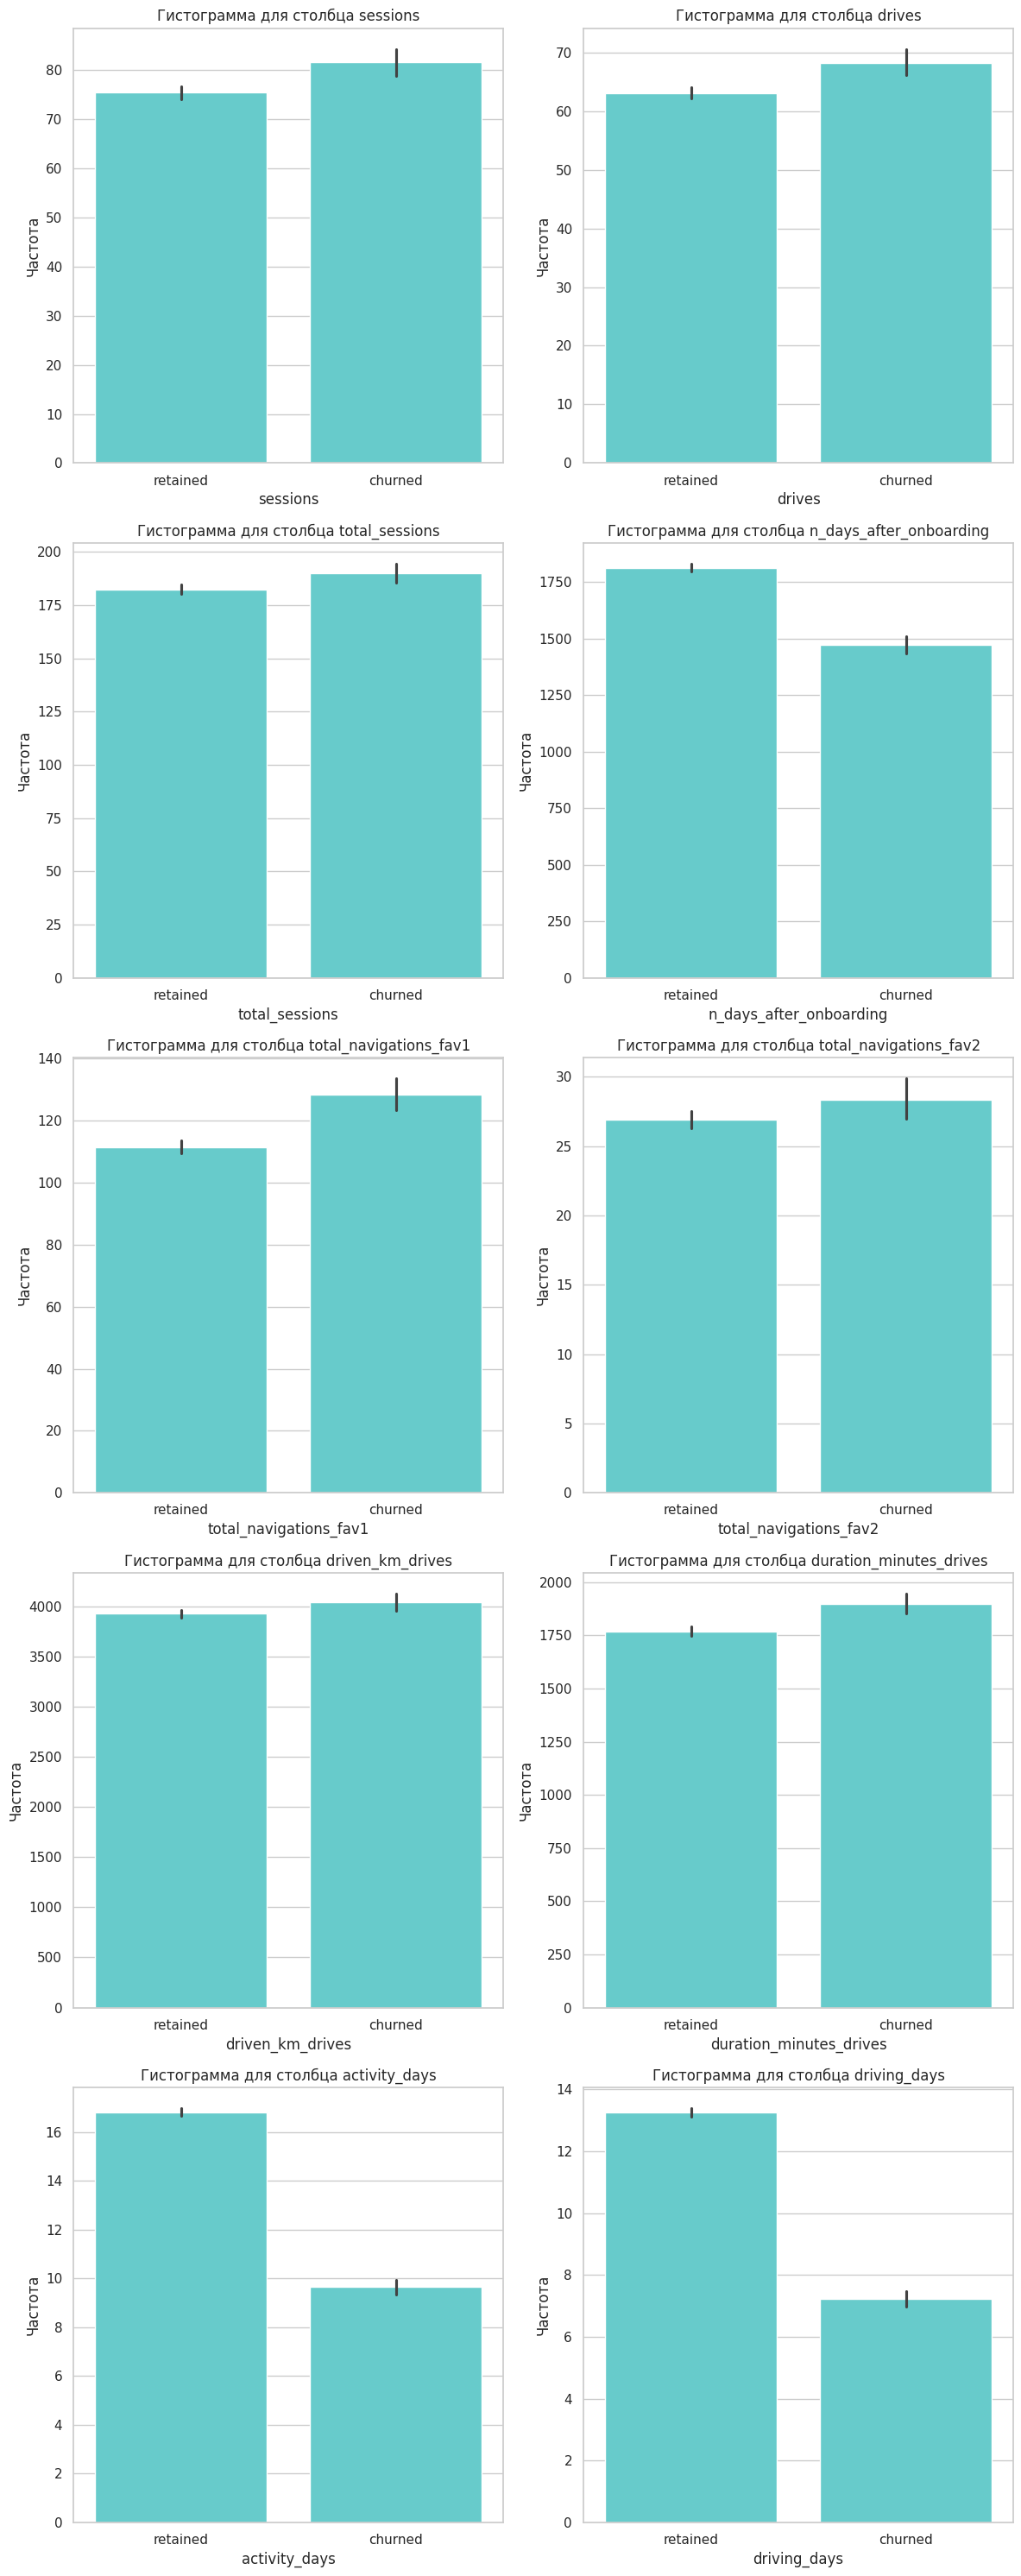

In [ ]:
num_plots = len(num)
num_rows = (num_plots + 1) // 2
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))
axes = axes.ravel()

for i, col in enumerate(num):
    sns.barplot(data=df, y=col, x='label', ax=axes[i])
    axes[i].set_title(f'Гистограмма для столбца {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

In [ ]:
columns_hist = ["n_days_after_onboarding", 'activity_days', 'driving_days']

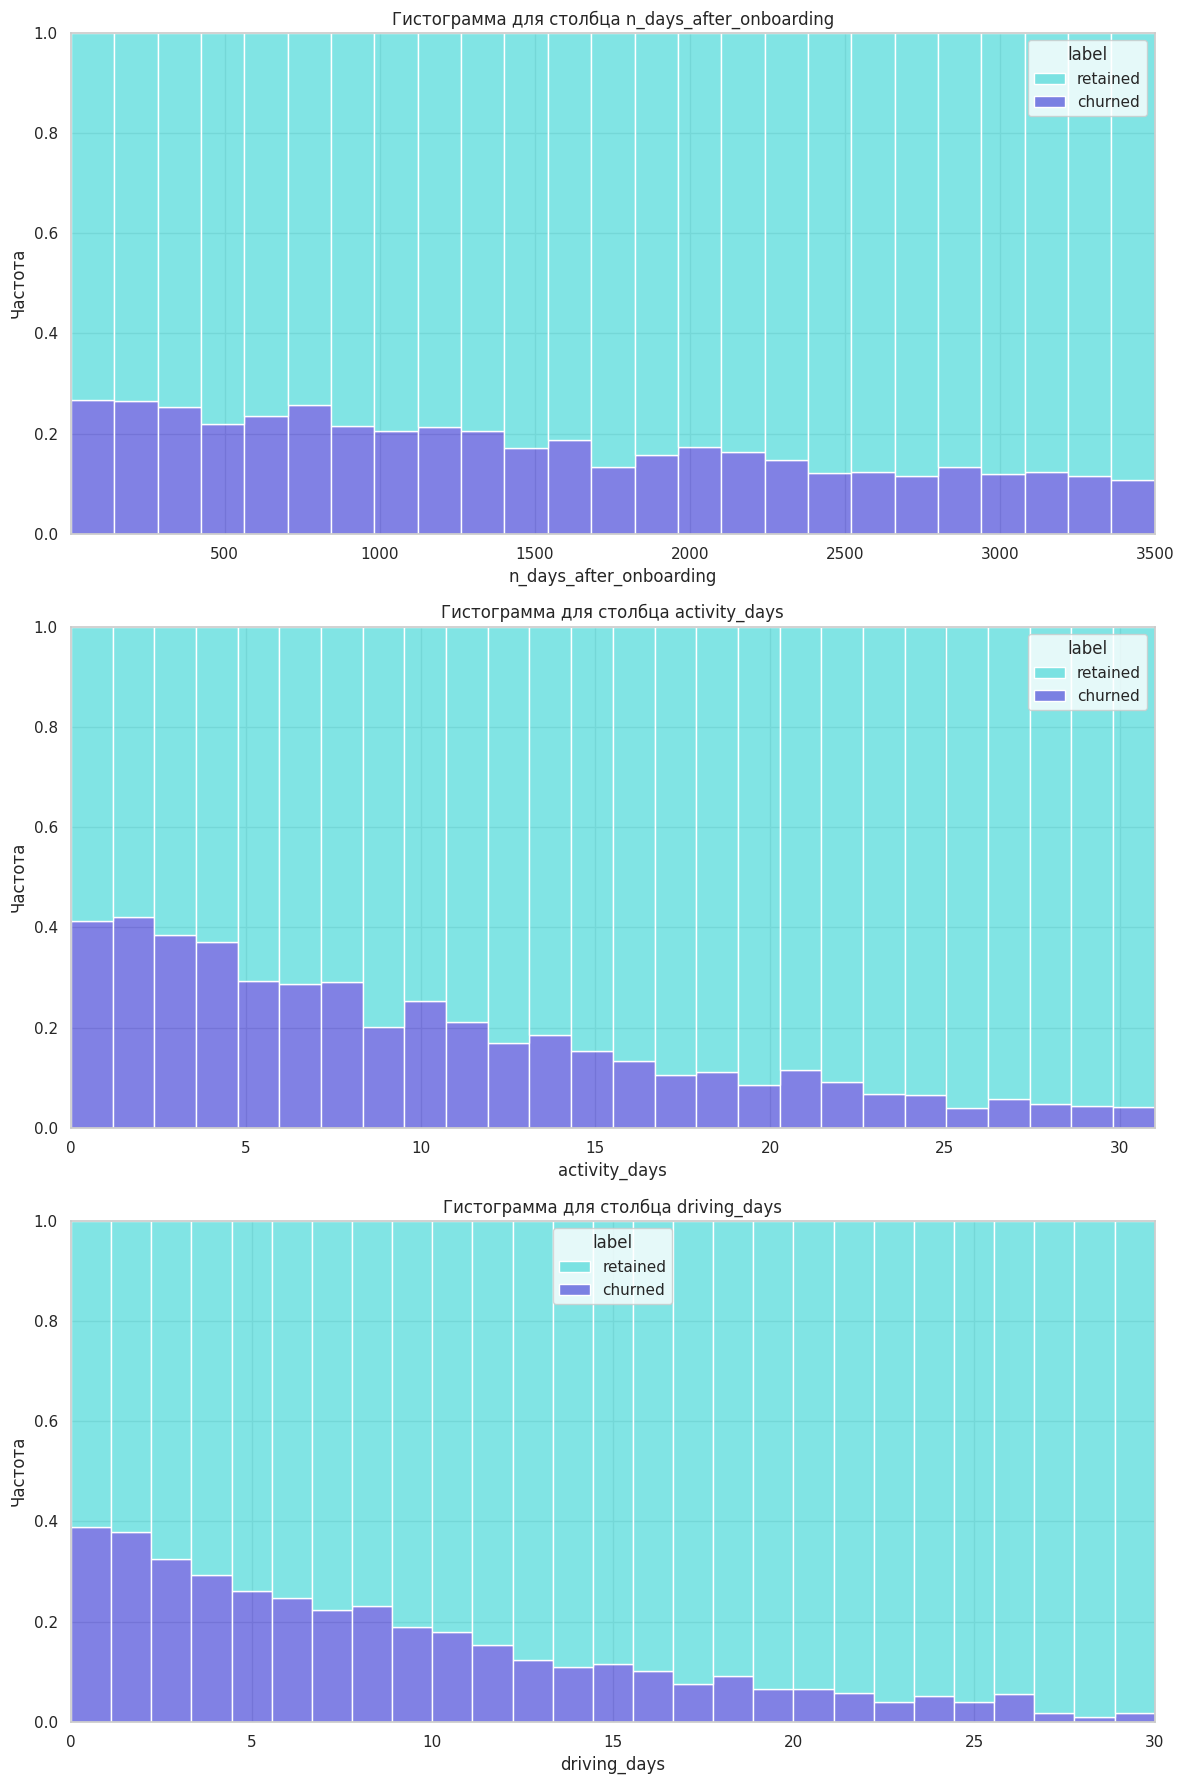

In [ ]:
num_plots = len(columns_hist)
num_rows = 3
num_cols = 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))
axes = axes.ravel()

for i, col in enumerate(columns_hist):
    sns.histplot(data=df, x=col, hue='label',multiple = "fill", ax=axes[i])
    axes[i].set_title(f'Гистограмма для столбца {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

Общее число сессий totel_sessions коррелирует с


In [ ]:
median_sessions = df['sessions'].median()
median_drives = df['sessions'].median()
df['taxi'] = np.where((df['sessions'] > median_sessions) & (df['drives'] > median_drives), 1, 0)

# Анализ номинативных признаков

### Label

In [ ]:
table_label = df.groupby(by = 'label')[['ID']].count()
table_label['percent'] = table_label.ID / len(df) * 100
table_label

,ID,percent
label,,
churned,2536,17.735506
retained,11763,82.264494


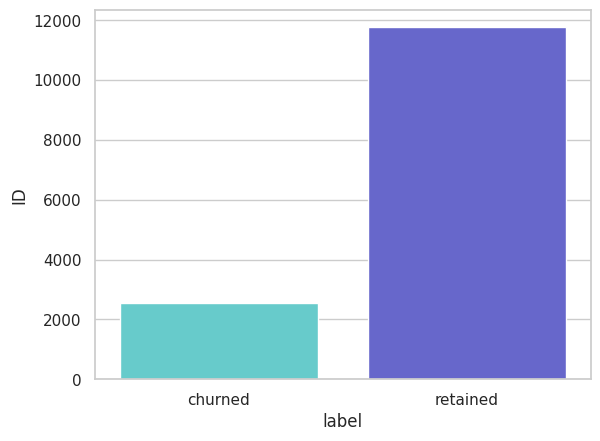

In [ ]:
ax = sns.barplot(x='label', y='ID', data=table_label.reset_index(), hue='label')

## Taxi

In [ ]:
table_taxi = df.groupby(by = 'taxi')[['ID']].count()
table_taxi['percent'] = table_taxi.ID / len(df) * 100
table_taxi

,ID,percent
taxi,,
0,8059,56.360585
1,6240,43.639415


<Axes: xlabel='taxi', ylabel='ID'>

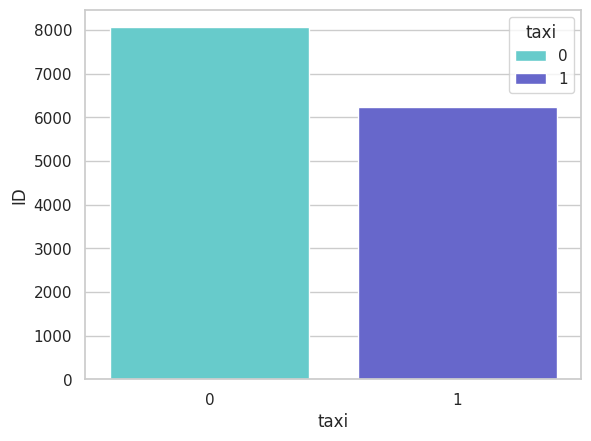

In [ ]:
sns.barplot(x='taxi', y='ID', data=table_taxi.reset_index(), hue='taxi')

In [ ]:
table_taxi = df.pivot_table(index = 'taxi', columns = 'label', aggfunc = 'size').reset_index()
table_taxi['percent'] = table_taxi['churned'] / table_taxi['retained']
table_taxi

label,taxi,churned,retained,percent
0,0,1390,6669,0.208427
1,1,1146,5094,0.224971


In [ ]:
px.bar(data_frame = table_taxi, x = 'taxi', y = ['churned', 'retained'], barmode='group', color_discrete_sequence =['#19D3F3', '#636EFA'])

## Device

In [ ]:
table_device = df.groupby(by = 'device')[['ID']].count().reset_index()
table_device['percent'] = table_device.ID / len(df) * 100
table_device

,device,ID,percent
0,Android,5074,35.484999
1,iPhone,9225,64.515001


<Axes: xlabel='device', ylabel='ID'>

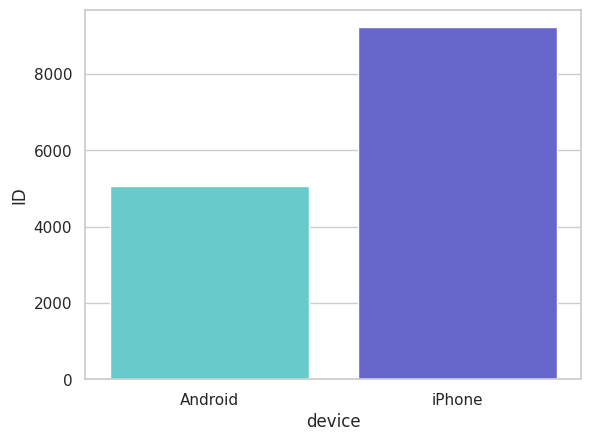

In [ ]:
sns.barplot(x='device', y='ID', data=table_device, hue='device')

In [ ]:
table_device_label = df.pivot_table(index = 'device', columns = 'label', aggfunc = 'size').reset_index()
table_device_label['percent'] = table_device_label['churned'] / table_device_label['retained']
table_device_label

label,device,churned,retained,percent
0,Android,891,4183,0.213005
1,iPhone,1645,7580,0.217018


In [ ]:
px.bar(data_frame = table_device_label, x = 'device', y = ['churned', 'retained'], barmode='group', color_discrete_sequence =['#19D3F3', '#636EFA'])

### Критерий согласия Пирсона

In [ ]:
ct = pd.crosstab(
    df.device,
    df.label
)
ct

label,churned,retained
device,,
Android,891,4183
iPhone,1645,7580


In [ ]:
res = chi2_contingency(ct)
print(res[0], res[1])

0.14772271238945212 0.7007211845963164


In [ ]:
p_value = 1 - scipy.stats.chi2.cdf(res[0], df=len(ct)-1)
p_value

0.7007211845963164

# Построение моделей

In [ ]:
num = ['sessions',
       'drives',
       'total_sessions',
       'n_days_after_onboarding',
       'total_navigations_fav1',
       'total_navigations_fav2',
       'driven_km_drives',
       'duration_minutes_drives',
       'activity_days',
       'driving_days']

cat = ['device', 'taxi']

columns = num + cat

In [ ]:
df.label.replace({'retained' : 1, 'churned' : 0}, inplace = True)

<ipython-input-79-f51552e4befc>:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-79-f51552e4befc>:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [ ]:
df_x = df[num+cat]
df_y = df.label

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.33, random_state = 42)

## Сэмплирование

Так как набор данных является несбалансированным (82% retained и 18% churned), необходимо применить метод сэмплирование, а именно андерсэмплинг - удалении элементов из слишком большого набора данных.

In [ ]:
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num),
        ('cat', categorical_transformer, cat)])

In [ ]:
X = preprocessor.fit_transform(df_x)
y = df_y

In [ ]:
columns_tl_x = ['sessions',
                    'drives',
                    'total_sessions',
                    'n_days_after_onboarding',
                    'total_navigations_fav1',
                    'total_navigations_fav2',
                    'driven_km_drives',
                    'duration_minutes_drives',
                    'activity_days',
                    'driving_days',
                    'taxi_1',
                    'taxi_2',
                    'device_1',
                    'device_2']

tl = TomekLinks()
X_tl, y_tl = tl.fit_resample(X, y)

In [ ]:
X_train_tl, X_test_tl, y_train_tl, y_test_tl = train_test_split(X_tl, y_tl, test_size = 0.33, random_state = 42)

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()



In [ ]:
X_smote, y_smote = smote.fit_resample(X, y)

In [ ]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size = 0.33, random_state = 42)

## Логистическая регрессия

### Модель 1. Логистическая регрессия

In [ ]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
log_reg = LogisticRegression(penalty = None, solver = 'newton-cg', max_iter = 300, random_state = 10)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', log_reg)])

parameters = [
    {'classifier__solver': ['newton-cg'], 'classifier__penalty': ['none'] },
    {'classifier__solver': ['saga'], 'classifier__max_iter':[300], 'classifier__penalty': ['elasticnet'], 'classifier__l1_ratio': np.arange(0, 1,0.1)},
    {'classifier__solver': ['saga'], 'classifier__penalty': ['l1'], 'classifier__C': np.arange(0, 0.5,0.1)},
    {'classifier__solver': ['newton-cg'], 'classifier__penalty': ['l2'], 'classifier__C': np.arange(0, 0.5,0.1)}]

log_reg_clf = GridSearchCV(pipeline, parameters, cv = kf, verbose = 2, scoring = 'roc_auc')

log_reg_clf.fit(X_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] END classifier__penalty=none, classifier__solver=newton-cg; total time=   0.0s
[CV] END classifier__penalty=none, classifier__solver=newton-cg; total time=   0.0s
[CV] END classifier__penalty=none, classifier__solver=newton-cg; total time=   0.0s
[CV] END classifier__penalty=none, classifier__solver=newton-cg; total time=   0.0s
[CV] END classifier__penalty=none, classifier__solver=newton-cg; total time=   0.0s
[CV] END classifier__l1_ratio=0.0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   0.7s
[CV] END classifier__l1_ratio=0.0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   0.7s
[CV] END classifier__l1_ratio=0.0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   0.8s
[CV] END classifier__l1_ratio=0.0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__so

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END classifier__l1_ratio=0.7000000000000001, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END classifier__l1_ratio=0.7000000000000001, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END classifier__l1_ratio=0.7000000000000001, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END classifier__l1_ratio=0.7000000000000001, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END classifier__l1_ratio=0.7000000000000001, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END classifier__l1_ratio=0.8, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END classifier__l1_ratio=0.8, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END classifier__l1_ratio=0.8, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END classifier__l1_ratio=0.8, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END classifier__l1_ratio=0.8, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END classifier__l1_ratio=0.9, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END classifier__l1_ratio=0.9, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END classifier__l1_ratio=0.9, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END classifier__l1_ratio=0.9, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END classifier__l1_ratio=0.9, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.8s
[CV] END classifier__C=0.0, classifier__penalty=l1, classifier__solver=saga; total time=   0.0s
[CV] END classifier__C=0.0, classifier__penalty=l1, classifier__solver=saga; total time=   0.0s
[CV] END classifier__C=0.0, classifier__penalty=l1, classifier__solver=saga; total time=   0.0s
[CV] END classifier__C=0.0, classifier__penalty=l1, classifier__solver=saga; total time=   0.0s
[CV] END classifier__C=0.0, classifier__penalty=l1, classifier__solver=saga; total time=   0.0s
[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.1s
[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.2s

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning:


15 fits failed out of a total of 105.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyt

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['sessions',
                                                                          'drives',
                                                                          'total_sessions',
                                                                          'n_days_after_onboarding',
                                                                          'total_navigations_fav1',
                                                                          'total_navigations_fav2',
                                                                          'driven_km_drives',
                                                                          'duration_minutes_drives',
                                                                          'activity_days',
                                                                          'dri...
                         {'classifier__l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                          'classifier__max_iter': [300],
                          'classifier__penalty': ['elasticnet'],
                          'classifier__solver': ['saga']},
                         {'classifier__C': array([0. , 0.1, 0.2, 0.3, 0.4]),
                          'classifier__penalty': ['l1'],
                          'classifier__solver': ['saga']},
                         {'classifier__C': array([0. , 0.1, 0.2, 0.3, 0.4]),
                          'classifier__penalty': ['l2'],
                          'classifier__solver': ['newton-cg']}],
             scoring='roc_auc', verbose=2)

In [ ]:
log_reg_clf.best_params_

{'classifier__C': 0.1,
 'classifier__penalty': 'l2',
 'classifier__solver': 'newton-cg'}

In [ ]:
log_reg_clf.best_score_

0.7513170458041398

In [ ]:
pred_train_log_reg_clf = log_reg_clf.best_estimator_.predict(X_train)

In [ ]:
print(classification_report(y_train, pred_train_log_reg_clf, labels = log_reg_clf.classes_))

              precision    recall  f1-score   support

           0       0.53      0.07      0.12      1677
           1       0.83      0.99      0.90      7903

    accuracy                           0.83      9580
   macro avg       0.68      0.53      0.51      9580
weighted avg       0.78      0.83      0.77      9580



In [ ]:
conf_matrix(y_train, pred_train_log_reg_clf, log_reg_clf.classes_.astype(str))

In [ ]:
pred_test_log_reg_clf = log_reg_clf.best_estimator_.predict(X_test)

In [ ]:
print(classification_report(y_test, pred_test_log_reg_clf, labels = log_reg_clf.classes_))

              precision    recall  f1-score   support

           0       0.65      0.08      0.14       859
           1       0.83      0.99      0.90      3860

    accuracy                           0.82      4719
   macro avg       0.74      0.53      0.52      4719
weighted avg       0.80      0.82      0.76      4719



In [ ]:
conf_matrix(y_test, pred_test_log_reg_clf, log_reg_clf.classes_.astype(str))

In [ ]:
probabilities_test_log_reg_clf = log_reg_clf.predict_proba(X_test)[:,1]
fpr, tpr, th = roc_curve(y_test, probabilities_test_log_reg_clf)

fig = px.area(x = fpr, y = tpr,
       labels = {
           'x':'False positive rate',
           'y': 'True positive rate'
                })
fig.add_trace(go.Scatter(x = [0,1], y=[0,1], marker_color = 'grey', showlegend = False))


### Логистическая регрессия. Изменение порога

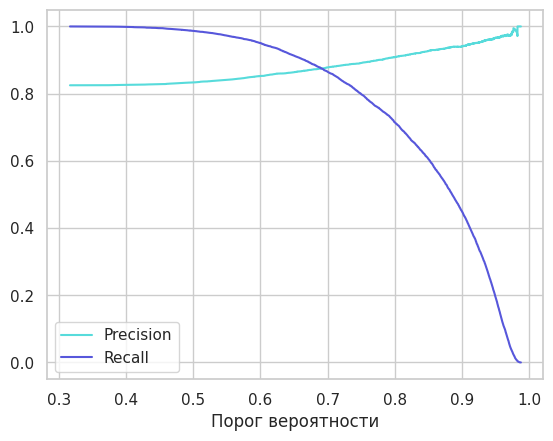

In [ ]:
prob_preds_train_log_reg_clf = log_reg_clf.best_estimator_.predict_proba(X_train)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_train, prob_preds_train_log_reg_clf)


plt.plot(thresholds, precision[:-1], label='Precision')
plt.xlabel('Порог вероятности')
plt.grid()


plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Порог вероятности')
plt.legend()
plt.grid()

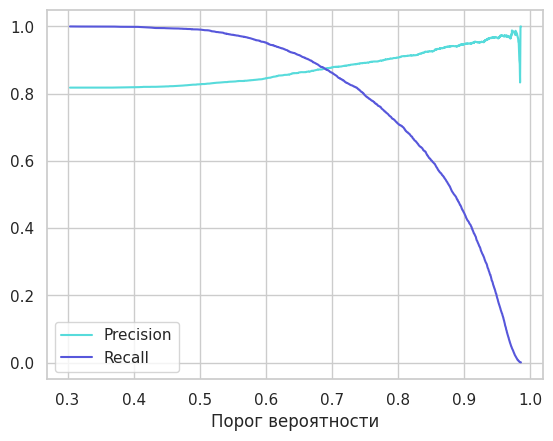

In [ ]:
prob_preds_test_log_reg_clf = log_reg_clf.best_estimator_.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, prob_preds_test_log_reg_clf)


plt.plot(thresholds, precision[:-1], label='Precision')
plt.xlabel('Порог вероятности')
plt.grid()


plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Порог вероятности')
plt.legend()
plt.grid()

In [ ]:
prob_preds_train_log_reg_clf = log_reg_clf.best_estimator_.predict_proba(X_train)

In [ ]:
prob_preds_test_log_reg_clf = log_reg_clf.best_estimator_.predict_proba(X_test)

In [ ]:
threshold = 0.81
pred_train_log_reg_clf = [1 if prob_preds_train_log_reg_clf[i][1]> threshold else 0 for i in range(len(prob_preds_train_log_reg_clf))]

In [ ]:
print(classification_report(y_train, pred_train_log_reg_clf, labels = log_reg_clf.classes_))

              precision    recall  f1-score   support

           0       0.32      0.69      0.44      1677
           1       0.91      0.69      0.79      7903

    accuracy                           0.69      9580
   macro avg       0.62      0.69      0.61      9580
weighted avg       0.81      0.69      0.73      9580



In [ ]:
conf_matrix(y_train, pred_train_log_reg_clf, log_reg_clf.classes_.astype(str))

In [ ]:
threshold = 0.81
pred_test_log_reg_clf = [1 if prob_preds_test_log_reg_clf[i][1]> threshold else 0 for i in range(len(prob_preds_test_log_reg_clf))]

In [ ]:
print(classification_report(y_test, pred_test_log_reg_clf, labels = log_reg_clf.classes_))

              precision    recall  f1-score   support

           0       0.34      0.70      0.45       859
           1       0.91      0.69      0.79      3860

    accuracy                           0.70      4719
   macro avg       0.62      0.70      0.62      4719
weighted avg       0.81      0.70      0.73      4719



In [ ]:
conf_matrix(y_test, pred_test_log_reg_clf, log_reg_clf.classes_.astype(str))

In [ ]:
fpr, tpr, th = roc_curve(y_test, prob_preds_test_log_reg_clf[:,1])

fig = px.area(x = fpr, y = tpr,
       labels = {
           'x':'False positive rate',
           'y': 'True positive rate'
                })
fig.add_trace(go.Scatter(x = [0,1], y=[0,1], marker_color = 'grey', showlegend = False))


### Модель 2. Логистическая регрессия на сэмплированных данных

In [ ]:
pipeline = Pipeline(steps=[('classifier', log_reg)]) #preprocessor теперь не нужен

In [ ]:
log_reg_clf_sample = GridSearchCV(pipeline, parameters, cv = kf, verbose = 2, scoring = 'roc_auc')

In [ ]:
log_reg_clf_sample.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] END classifier__penalty=none, classifier__solver=newton-cg; total time=   0.0s
[CV] END classifier__penalty=none, classifier__solver=newton-cg; total time=   0.0s
[CV] END classifier__penalty=none, classifier__solver=newton-cg; total time=   0.0s
[CV] END classifier__penalty=none, classifier__solver=newton-cg; total time=   0.0s
[CV] END classifier__penalty=none, classifier__solver=newton-cg; total time=   0.0s
[CV] END classifier__l1_ratio=0.0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.5s
[CV] END classifier__l1_ratio=0.0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.8s
[CV] END classifier__l1_ratio=0.0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   2.0s
[CV] END classifier__l1_ratio=0.0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__so

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END classifier__l1_ratio=0.7000000000000001, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.7s
[CV] END classifier__l1_ratio=0.7000000000000001, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.7s
[CV] END classifier__l1_ratio=0.7000000000000001, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END classifier__l1_ratio=0.8, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   2.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END classifier__l1_ratio=0.8, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END classifier__l1_ratio=0.8, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   2.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END classifier__l1_ratio=0.8, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END classifier__l1_ratio=0.8, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END classifier__l1_ratio=0.9, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END classifier__l1_ratio=0.9, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END classifier__l1_ratio=0.9, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END classifier__l1_ratio=0.9, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[CV] END classifier__l1_ratio=0.9, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   2.6s
[CV] END classifier__C=0.0, classifier__penalty=l1, classifier__solver=saga; total time=   0.0s
[CV] END classifier__C=0.0, classifier__penalty=l1, classifier__solver=saga; total time=   0.0s
[CV] END classifier__C=0.0, classifier__penalty=l1, classifier__solver=saga; total time=   0.0s
[CV] END classifier__C=0.0, classifier__penalty=l1, classifier__solver=saga; total time=   0.0s
[CV] END classifier__C=0.0, classifier__penalty=l1, classifier__solver=saga; total time=   0.0s
[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.2s

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning:


15 fits failed out of a total of 105.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyt

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('classifier',
                                        LogisticRegression(max_iter=300,
                                                           penalty=None,
                                                           random_state=10,
                                                           solver='newton-cg'))]),
             param_grid=[{'classifier__penalty': ['none'],
                          'classifier__solver': ['newton-cg']},
                         {'classifier__l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                          'classifier__max_iter': [300],
                          'classifier__penalty': ['elasticnet'],
                          'classifier__solver': ['saga']},
                         {'classifier__C': array([0. , 0.1, 0.2, 0.3, 0.4]),
                          'classifier__penalty': ['l1'],
                          'classifier__solver': ['saga']},
                         {'classifier__C': array([0. , 0.1, 0.2, 0.3, 0.4]),
                          'classifier__penalty': ['l2'],
                          'classifier__solver': ['newton-cg']}],
             scoring='roc_auc', verbose=2)

In [ ]:
log_reg_clf_sample.best_params_

{'classifier__C': 0.2,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [ ]:
log_reg_clf_sample.best_score_

0.7637723272376081

In [ ]:
pred_test_log_reg_clf_sample = log_reg_clf_sample.best_estimator_.predict(X_test_smote)

In [ ]:
pred_train_log_reg_clf_sample = log_reg_clf_sample.best_estimator_.predict(X_train_smote)

In [ ]:
print(classification_report(y_train_smote, pred_train_log_reg_clf_sample, labels = log_reg_clf_sample.classes_))

              precision    recall  f1-score   support

           0       0.69      0.72      0.70      7867
           1       0.71      0.67      0.69      7895

    accuracy                           0.70     15762
   macro avg       0.70      0.70      0.70     15762
weighted avg       0.70      0.70      0.70     15762



In [ ]:
print(classification_report(y_test_smote, pred_test_log_reg_clf_sample, labels = log_reg_clf_sample.classes_))

              precision    recall  f1-score   support

           0       0.68      0.74      0.71      3896
           1       0.71      0.66      0.68      3868

    accuracy                           0.70      7764
   macro avg       0.70      0.70      0.70      7764
weighted avg       0.70      0.70      0.70      7764



In [ ]:
conf_matrix(y_test_tl, pred_test_log_reg_clf_sample, log_reg_clf_sample.classes_.astype(str))

In [ ]:
print(classification_report(y_test_tl, pred_test_log_reg_clf_sample, labels = log_reg_clf_sample.classes_))

              precision    recall  f1-score   support

           0       0.61      0.16      0.26       819
           1       0.84      0.98      0.90      3596

    accuracy                           0.83      4415
   macro avg       0.73      0.57      0.58      4415
weighted avg       0.80      0.83      0.78      4415



In [ ]:
probabilities_test = log_reg_clf_sample.predict_proba(X_test_tl)[:,1]
fpr, tpr, th = roc_curve(y_test_tl, probabilities_test)

fig = px.area(x = fpr, y = tpr,
       labels = {
           'x':'False positive rate',
           'y': 'True positive rate'
                })
fig.add_trace(go.Scatter(x = [0,1], y=[0,1], marker_color = 'grey', showlegend = False))

### Логистическая регрессия с сэмплированием. Изменение порога

In [ ]:
prob_preds_test_log_reg_clf_sample = log_reg_clf_sample.best_estimator_.predict_proba(X_test_tl)

In [ ]:
threshold = 0.8
pred_test_log_reg_clf_sample = [1 if prob_preds_test_log_reg_clf_sample[i][1]> threshold else 0 for i in range(len(prob_preds_test_log_reg_clf_sample))]

In [ ]:
conf_matrix(y_test_tl, pred_test_log_reg_clf_sample, log_reg_clf_sample.classes_.astype(str))

In [ ]:
print(classification_report(y_test_tl, pred_test_log_reg_clf_sample, labels = log_reg_clf_sample.classes_))

              precision    recall  f1-score   support

           0       0.36      0.71      0.48       819
           1       0.91      0.72      0.80      3596

    accuracy                           0.72      4415
   macro avg       0.64      0.71      0.64      4415
weighted avg       0.81      0.72      0.74      4415



In [ ]:
fpr, tpr, th = roc_curve(y_test_tl, prob_preds_test_log_reg_clf_sample[:,1])

fig = px.area(x = fpr, y = tpr,
       labels = {
           'x':'False positive rate',
           'y': 'True positive rate'
                })
fig.add_trace(go.Scatter(x = [0,1], y=[0,1], marker_color = 'grey', showlegend = False))

In [ ]:
log_reg_clf.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] END classifier__penalty=none, classifier__solver=newton-cg; total time=   0.0s
[CV] END classifier__penalty=none, classifier__solver=newton-cg; total time=   0.0s
[CV] END classifier__penalty=none, classifier__solver=newton-cg; total time=   0.0s
[CV] END classifier__penalty=none, classifier__solver=newton-cg; total time=   0.0s
[CV] END classifier__penalty=none, classifier__solver=newton-cg; total time=   0.0s
[CV] END classifier__l1_ratio=0.0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   0.0s
[CV] END classifier__l1_ratio=0.0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   0.0s
[CV] END classifier__l1_ratio=0.0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga; total time=   0.0s
[CV] END classifier__l1_ratio=0.0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__so

ValueError: 
All the 105 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
105 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_indexing.py", line 338, in _get_column_indices
    all_columns = X.columns
AttributeError: 'numpy.ndarray' object has no attribute 'columns'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 406, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/dist-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py", line 968, in fit_transform
    self._validate_column_callables(X)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py", line 536, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_indexing.py", line 340, in _get_column_indices
    raise ValueError(
ValueError: Specifying the columns using strings is only supported for dataframes.


In [ ]:
log_reg_clf_sample.best_params_

### Отбор данных на лучшей модели регрессии

#### Оценка feature importance

In [ ]:
bm = log_reg_clf_sample.best_estimator_

In [ ]:
weights = bm.named_steps['classifier'].coef_.round(2)[0]

In [ ]:
features = columns_tl_x
features

['sessions',
 'drives',
 'total_sessions',
 'n_days_after_onboarding',
 'total_navigations_fav1',
 'total_navigations_fav2',
 'driven_km_drives',
 'duration_minutes_drives',
 'activity_days',
 'driving_days',
 'taxi_1',
 'taxi_2',
 'device_1',
 'device_2']

In [ ]:
feature_importance = pd.Series({k: v for k, v in zip(features , weights)})

In [ ]:
feature_importance

,0
sessions,-0.05
drives,-0.20
total_sessions,-0.01
n_days_after_onboarding,0.42
total_navigations_fav1,-0.15
total_navigations_fav2,-0.05
driven_km_drives,0.05
duration_minutes_drives,-0.15
activity_days,0.71
driving_days,0.29


In [ ]:
px.bar(feature_importance.sort_values(key = lambda x: abs(x), ascending=False), orientation = 'h')

In [ ]:
from sklearn.feature_selection import RFE, RFECV
from sklearn.feature_selection import SequentialFeatureSelector

#### RFECV

In [ ]:
log_reg = LogisticRegression(C= 0.1, penalty='l2', solver='newton-cg')
rfe_cv = RFECV(estimator = log_reg, cv = kf, scoring = 'roc_auc')
rfe_model_cv = Pipeline(steps=[
    ('feature selection',rfe_cv),
    ('classifier', log_reg)])

rfe_model_cv.fit(X_train_tl, y_train_tl)

Pipeline(steps=[('feature selection',
                 RFECV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                       estimator=LogisticRegression(C=0.1, solver='newton-cg'),
                       scoring='roc_auc')),
                ('classifier', LogisticRegression(C=0.1, solver='newton-cg'))])

In [ ]:
rfe_cv.n_features_

10

In [ ]:
selected_features_cv = pd.DataFrame(rfe_cv.support_, index = features, columns=['Rank'])
selected_features_cv[selected_features_cv['Rank']]

,Rank
drives,True
n_days_after_onboarding,True
total_navigations_fav1,True
total_navigations_fav2,True
duration_minutes_drives,True
activity_days,True
driving_days,True
taxi_2,True
device_1,True
device_2,True


In [ ]:
result = rfe_cv.cv_results_['mean_test_score']
px.scatter(x = np.arange(0, len(result)), y = result, labels ={'x': 'Количество признаков', 'y': 'ROC_AUC'})

#### SFS

In [ ]:
sfs_forward = SequentialFeatureSelector(log_reg, n_features_to_select=10, direction="forward")

sfs_forward_p = Pipeline(steps=[
                      ('SequentialFeatureSelector', sfs_forward),
                          ('classifier', log_reg) ])

parameters = [{'SequentialFeatureSelector__n_features_to_select' : [9, 10, 11]}]

sfs_forward_p_clf = GridSearchCV(sfs_forward_p, parameters, cv=kf, verbose=2, scoring='roc_auc')
sfs_forward_p_clf.fit(X_train_tl, y_train_tl)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ..SequentialFeatureSelector__n_features_to_select=9; total time=   9.2s
[CV] END ..SequentialFeatureSelector__n_features_to_select=9; total time=   6.9s
[CV] END ..SequentialFeatureSelector__n_features_to_select=9; total time=  13.8s
[CV] END ..SequentialFeatureSelector__n_features_to_select=9; total time=  13.1s
[CV] END ..SequentialFeatureSelector__n_features_to_select=9; total time=   6.6s
[CV] END .SequentialFeatureSelector__n_features_to_select=10; total time=  10.1s
[CV] END .SequentialFeatureSelector__n_features_to_select=10; total time=   7.3s
[CV] END .SequentialFeatureSelector__n_features_to_select=10; total time=  10.3s
[CV] END .SequentialFeatureSelector__n_features_to_select=10; total time=   8.6s
[CV] END .SequentialFeatureSelector__n_features_to_select=10; total time=  16.9s
[CV] END .SequentialFeatureSelector__n_features_to_select=11; total time=  21.0s
[CV] END .SequentialFeatureSelector__n_features_t

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('SequentialFeatureSelector',
                                        SequentialFeatureSelector(estimator=LogisticRegression(C=0.1,
                                                                                               solver='newton-cg'),
                                                                  n_features_to_select=10)),
                                       ('classifier',
                                        LogisticRegression(C=0.1,
                                                           solver='newton-cg'))]),
             param_grid=[{'SequentialFeatureSelector__n_features_to_select': [9,
                                                                              10,
                                                                              11]}],
             scoring='roc_auc', verbose=2)

In [ ]:
sfs_forward_p = Pipeline(steps=[
                      ('SequentialFeatureSelector', sfs_forward),
                          ('classifier', log_reg) ])

In [ ]:
parameters = [{'SequentialFeatureSelector__n_features_to_select' : [9, 10, 11]}]

In [ ]:
sfs_forward_p_clf = GridSearchCV(sfs_forward_p, parameters, cv=kf, verbose=2, scoring='roc_auc')
sfs_forward_p_clf.fit(X_train_tl, y_train_tl)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ..SequentialFeatureSelector__n_features_to_select=9; total time=   7.0s
[CV] END ..SequentialFeatureSelector__n_features_to_select=9; total time=   9.7s
[CV] END ..SequentialFeatureSelector__n_features_to_select=9; total time=   8.7s
[CV] END ..SequentialFeatureSelector__n_features_to_select=9; total time=   7.4s
[CV] END ..SequentialFeatureSelector__n_features_to_select=9; total time=   8.6s
[CV] END .SequentialFeatureSelector__n_features_to_select=10; total time=   7.6s
[CV] END .SequentialFeatureSelector__n_features_to_select=10; total time=  11.1s
[CV] END .SequentialFeatureSelector__n_features_to_select=10; total time=   7.1s
[CV] END .SequentialFeatureSelector__n_features_to_select=10; total time=  10.2s
[CV] END .SequentialFeatureSelector__n_features_to_select=10; total time=   7.2s
[CV] END .SequentialFeatureSelector__n_features_to_select=11; total time=  12.2s
[CV] END .SequentialFeatureSelector__n_features_t

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('SequentialFeatureSelector',
                                        SequentialFeatureSelector(estimator=LogisticRegression(C=0.1,
                                                                                               solver='newton-cg'),
                                                                  n_features_to_select=10)),
                                       ('classifier',
                                        LogisticRegression(C=0.1,
                                                           solver='newton-cg'))]),
             param_grid=[{'SequentialFeatureSelector__n_features_to_select': [9,
                                                                              10,
                                                                              11]}],
             scoring='roc_auc', verbose=2)

In [ ]:
b =  sfs_forward_p_clf.best_estimator_

In [ ]:
print("Отобранные признаки (прямой отбор):", b.named_steps['SequentialFeatureSelector'].get_support(indices=True))

Отобранные признаки (прямой отбор): [ 0  1  3  4  5  7  8  9 10 12 13]


In [ ]:
features_to_select_ind = b.named_steps['SequentialFeatureSelector'].get_support()
features_to_select = []
for i in range(len(features_to_select_ind)):
    if features_to_select_ind[i]:
        features_to_select.append(columns_tl_x[i])
features_to_select
#добавили sessions, taxi_1 вместо taxi_2

['sessions',
 'drives',
 'n_days_after_onboarding',
 'total_navigations_fav1',
 'total_navigations_fav2',
 'duration_minutes_drives',
 'activity_days',
 'driving_days',
 'taxi_1',
 'device_1',
 'device_2']

In [ ]:
sfs_backward = SequentialFeatureSelector(log_reg, n_features_to_select=10, direction="backward")

sfs_backward_p = Pipeline(steps=[
                      ('SequentialFeatureSelector', sfs_backward),
                          ('classifier', log_reg) ])

parameters = [{'SequentialFeatureSelector__n_features_to_select' : [9, 10, 11]}]

sfs_backward_p_clf = GridSearchCV(sfs_backward_p, parameters, cv=kf, verbose=2, scoring='roc_auc')
sfs_backward_p_clf.fit(X_train_tl, y_train_tl)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ..SequentialFeatureSelector__n_features_to_select=9; total time=  22.7s
[CV] END ..SequentialFeatureSelector__n_features_to_select=9; total time=  13.0s
[CV] END ..SequentialFeatureSelector__n_features_to_select=9; total time=   7.7s
[CV] END ..SequentialFeatureSelector__n_features_to_select=9; total time=  10.0s
[CV] END ..SequentialFeatureSelector__n_features_to_select=9; total time=   6.9s
[CV] END .SequentialFeatureSelector__n_features_to_select=10; total time=   9.0s
[CV] END .SequentialFeatureSelector__n_features_to_select=10; total time=   5.8s
[CV] END .SequentialFeatureSelector__n_features_to_select=10; total time=   7.8s
[CV] END .SequentialFeatureSelector__n_features_to_select=10; total time=   7.0s
[CV] END .SequentialFeatureSelector__n_features_to_select=10; total time=   6.7s
[CV] END .SequentialFeatureSelector__n_features_to_select=11; total time=   6.8s
[CV] END .SequentialFeatureSelector__n_features_t

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('SequentialFeatureSelector',
                                        SequentialFeatureSelector(direction='backward',
                                                                  estimator=LogisticRegression(C=0.1,
                                                                                               solver='newton-cg'),
                                                                  n_features_to_select=10)),
                                       ('classifier',
                                        LogisticRegression(C=0.1,
                                                           solver='newton-cg'))]),
             param_grid=[{'SequentialFeatureSelector__n_features_to_select': [9,
                                                                              10,
                                                                              11]}],
             scoring='roc_auc', verbose=2)

In [ ]:
b =  sfs_forward_p_clf.best_estimator_

In [ ]:
print("Отобранные признаки (прямой отбор):", b.named_steps['SequentialFeatureSelector'].get_support(indices=True))

Отобранные признаки (прямой отбор): [ 0  1  3  4  5  7  8  9 10 12 13]


In [ ]:
features_to_select_ind = b.named_steps['SequentialFeatureSelector'].get_support()
features_to_select = []
for i in range(len(features_to_select_ind)):
    if features_to_select_ind[i]:
        features_to_select.append(columns_tl_x[i])
features_to_select
#добавили sessions, taxi_1 вместо taxi_2

['sessions',
 'drives',
 'n_days_after_onboarding',
 'total_navigations_fav1',
 'total_navigations_fav2',
 'duration_minutes_drives',
 'activity_days',
 'driving_days',
 'taxi_1',
 'device_1',
 'device_2']

## Метод опорных векторов

### Модель 3. Линейная модель опорных векторов.

In [ ]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
linear_svm = CalibratedClassifierCV(svm.LinearSVC(class_weight = 'balanced'))

pipeline = Pipeline(steps=[ ('classifier', linear_svm)])

parameters = [
    {'classifier__estimator__penalty': ['l1'], 'classifier__estimator__C': np.arange(0,50,10) },
    {'classifier__estimator__penalty': ['l2'], 'classifier__estimator__C': np.arange(0,50,10)}]

linear_svm_model_clf = GridSearchCV(pipeline, parameters, cv = kf, verbose = 3, scoring = 'roc_auc')

linear_svm_model_clf.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END classifier__estimator__C=0, classifier__estimator__penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END classifier__estimator__C=0, classifier__estimator__penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END classifier__estimator__C=0, classifier__estimator__penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END classifier__estimator__C=0, classifier__estimator__penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END classifier__estimator__C=0, classifier__estimator__penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END classifier__estimator__C=10, classifier__estimator__penalty=l1;, score=0.760 total time=   2.4s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 2/5] END classifier__estimator__C=10, classifier__estimator__penalty=l1;, score=0.769 total time=   3.9s
[CV 3/5] END classifier__estimator__C=10, classifier__estimator__penalty=l1;, score=0.760 total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 4/5] END classifier__estimator__C=10, classifier__estimator__penalty=l1;, score=0.766 total time=   2.7s
[CV 5/5] END classifier__estimator__C=10, classifier__estimator__penalty=l1;, score=0.763 total time=   1.8s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 1/5] END classifier__estimator__C=20, classifier__estimator__penalty=l1;, score=0.760 total time=   2.3s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 2/5] END classifier__estimator__C=20, classifier__estimator__penalty=l1;, score=0.769 total time=   3.3s
[CV 3/5] END classifier__estimator__C=20, classifier__estimator__penalty=l1;, score=0.760 total time=   2.4s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 4/5] END classifier__estimator__C=20, classifier__estimator__penalty=l1;, score=0.766 total time=   5.7s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 5/5] END classifier__estimator__C=20, classifier__estimator__penalty=l1;, score=0.763 total time=   2.8s
[CV 1/5] END classifier__estimator__C=30, classifier__estimator__penalty=l1;, score=0.760 total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 2/5] END classifier__estimator__C=30, classifier__estimator__penalty=l1;, score=0.769 total time=   3.0s
[CV 3/5] END classifier__estimator__C=30, classifier__estimator__penalty=l1;, score=0.760 total time=   3.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 4/5] END classifier__estimator__C=30, classifier__estimator__penalty=l1;, score=0.766 total time=   3.1s
[CV 5/5] END classifier__estimator__C=30, classifier__estimator__penalty=l1;, score=0.763 total time=   2.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 1/5] END classifier__estimator__C=40, classifier__estimator__penalty=l1;, score=0.760 total time=   2.9s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 2/5] END classifier__estimator__C=40, classifier__estimator__penalty=l1;, score=0.769 total time=   3.1s
[CV 3/5] END classifier__estimator__C=40, classifier__estimator__penalty=l1;, score=0.760 total time=   2.9s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[CV 4/5] END classifier__estimator__C=40, classifier__estimator__penalty=l1;, score=0.766 total time=   5.6s
[CV 5/5] END classifier__estimator__C=40, classifier__estimator__penalty=l1;, score=0.763 total time=   2.9s
[CV 1/5] END classifier__estimator__C=0, classifier__estimator__penalty=l2;, score=nan total time=   0.0s
[CV 2/5] END classifier__estimator__C=0, classifier__estimator__penalty=l2;, score=nan total time=   0.0s
[CV 3/5] END classifier__estimator__C=0, classifier__estimator__penalty=l2;, score=nan total time=   0.0s
[CV 4/5] END classifier__estimator__C=0, classifier__estimator__penalty=l2;, score=nan total time=   0.0s
[CV 5/5] END classifier__estimator__C=0, classifier__estimator__penalty=l2;, score=nan total time=   0.0s
[CV 1/5] END classifier__estimator__C=10, classifier__estimator__penalty=l2;, score=0.760 total time=   0.3s
[CV 2/5] END classifier__estimator__C=10, classifier__estimator__penalty=l2;, score=0.769 total time=   0.3s
[CV 3/5] END classifier__estimator

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning:


10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyt

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('classifier',
                                        CalibratedClassifierCV(estimator=LinearSVC(class_weight='balanced')))]),
             param_grid=[{'classifier__estimator__C': array([ 0, 10, 20, 30, 40]),
                          'classifier__estimator__penalty': ['l1']},
                         {'classifier__estimator__C': array([ 0, 10, 20, 30, 40]),
                          'classifier__estimator__penalty': ['l2']}],
             scoring='roc_auc', verbose=3)

In [ ]:
linear_svm_model_clf.best_params_

{'classifier__estimator__C': 10, 'classifier__estimator__penalty': 'l2'}

In [ ]:
linear_svm_model_clf.best_score_

0.7637167838130308

In [ ]:
pred_test_linear_svm_model_clf = linear_svm_model_clf.predict(X_test_smote)
pred_train_linear_svm_model_clf = linear_svm_model_clf.predict(X_train_smote)

In [ ]:
print(classification_report(y_test_smote, pred_test_linear_svm_model_clf, labels = linear_svm_model_clf.classes_))

              precision    recall  f1-score   support

           0       0.69      0.74      0.71      3896
           1       0.72      0.66      0.69      3868

    accuracy                           0.70      7764
   macro avg       0.70      0.70      0.70      7764
weighted avg       0.70      0.70      0.70      7764



In [ ]:
conf_matrix(y_test_smote, pred_test_linear_svm_model_clf, linear_svm_model_clf.classes_.astype(str))

In [ ]:
probabilities_test = linear_svm_model_clf.predict_proba(X_test_smote)[:,1]
fpr, tpr, th = roc_curve(y_test_smote, probabilities_test)

fig = px.area(x = fpr, y = tpr,
       labels = {
           'x':'False positive rate',
           'y': 'True positive rate'
                })
fig.add_trace(go.Scatter(x = [0,1], y=[0,1], marker_color = 'grey', showlegend = False))

### Модель 4. Метод опорных векторов (обобщенный)

In [ ]:
svm_model = CalibratedClassifierCV(svm.SVC())
#parameters = [{'classifier__estimator__kernel': ['poly', 'rbf', 'sigmoid'], 'classifier__estimator__C': np.arange(0, 1, 0.1)}]
parameters = [{'classifier__estimator__kernel': ['poly'], 'classifier__estimator__C': [0.1]}]
pipeline = Pipeline(steps=[('classifier', svm_model)])
svm_clf_sample = GridSearchCV(pipeline, parameters, cv = kf, verbose = 3, scoring = 'roc_auc')
svm_clf_sample.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END classifier__estimator__C=0.1, classifier__estimator__kernel=poly;, score=0.757 total time=  32.7s
[CV 2/5] END classifier__estimator__C=0.1, classifier__estimator__kernel=poly;, score=0.769 total time=  32.9s
[CV 3/5] END classifier__estimator__C=0.1, classifier__estimator__kernel=poly;, score=0.762 total time=  31.7s
[CV 4/5] END classifier__estimator__C=0.1, classifier__estimator__kernel=poly;, score=0.770 total time=  32.8s
[CV 5/5] END classifier__estimator__C=0.1, classifier__estimator__kernel=poly;, score=0.763 total time=  34.0s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('classifier',
                                        CalibratedClassifierCV(estimator=SVC()))]),
             param_grid=[{'classifier__estimator__C': [0.1],
                          'classifier__estimator__kernel': ['poly']}],
             scoring='roc_auc', verbose=3)

In [ ]:
svm_clf_sample.best_params_

{'classifier__estimator__C': 0.1, 'classifier__estimator__kernel': 'poly'}

In [ ]:
svm_clf_sample.best_score_

0.7643525185255136

In [ ]:
pred_test_svm_clf = svm_clf_sample.best_estimator_.predict(X_test_smote)

In [ ]:
print(classification_report(y_test_smote, pred_test_svm_clf, labels = svm_clf_sample.classes_))

              precision    recall  f1-score   support

           0       0.69      0.70      0.70      3896
           1       0.70      0.69      0.69      3868

    accuracy                           0.70      7764
   macro avg       0.70      0.69      0.69      7764
weighted avg       0.70      0.70      0.69      7764



In [ ]:
conf_matrix(y_test_smote, pred_test_svm_clf, svm_clf_sample.classes_.astype(str))

In [ ]:
svm_clf.predict_proba(X_train_smote)

### Отбор факторов по лучшей модели опорных векторов - линейной

## Метод ближайших соседей

### Модель 8. Метод ближайших соседей с семплированием

In [ ]:
knn = KNeighborsClassifier()
pipeline = Pipeline(steps=[('classifier', knn)])

parameters = {
    'classifier__n_neighbors': [2, 3, 4, 5],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']}

clf_knn = GridSearchCV(pipeline, parameters, cv = kf, verbose = 3, scoring = 'roc_auc')

In [ ]:
clf_knn.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END classifier__metric=euclidean, classifier__n_neighbors=2, classifier__weights=uniform;, score=0.857 total time=   0.2s
[CV 2/5] END classifier__metric=euclidean, classifier__n_neighbors=2, classifier__weights=uniform;, score=0.859 total time=   0.2s
[CV 3/5] END classifier__metric=euclidean, classifier__n_neighbors=2, classifier__weights=uniform;, score=0.865 total time=   0.2s
[CV 4/5] END classifier__metric=euclidean, classifier__n_neighbors=2, classifier__weights=uniform;, score=0.873 total time=   0.2s
[CV 5/5] END classifier__metric=euclidean, classifier__n_neighbors=2, classifier__weights=uniform;, score=0.872 total time=   0.2s
[CV 1/5] END classifier__metric=euclidean, classifier__n_neighbors=2, classifier__weights=distance;, score=0.864 total time=   0.2s
[CV 2/5] END classifier__metric=euclidean, classifier__n_neighbors=2, classifier__weights=distance;, score=0.868 total time=   0.2s
[CV 3/5] END classif

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast



GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__metric': ['euclidean', 'manhattan'],
                         'classifier__n_neighbors': [2, 3, 4, 5],
                         'classifier__weights': ['uniform', 'distance']},
             scoring='roc_auc', verbose=3)

In [ ]:
clf_knn.best_params_

{'classifier__metric': 'manhattan',
 'classifier__n_neighbors': 5,
 'classifier__weights': 'distance'}

In [ ]:
clf_knn.best_score_

0.9077045616945567

In [ ]:
pred_train_knn = clf_knn.best_estimator_.predict(X_train_smote)

In [ ]:
roc_auc_score(y_train_smote, clf_knn.predict_proba(X_train_smote)[:,1])

1.0

In [ ]:
clf_knn.score(X_train_smote, y_train_smote)

1.0

In [ ]:
accuracy_score(y_train_smote, pred_train_knn)

1.0

In [ ]:
conf_matrix(y_train_smote, pred_train_knn, clf_knn.classes_.astype(str))

In [ ]:
pred_test_knn = clf_knn.best_estimator_.predict(X_test_smote)

In [ ]:
roc_auc_score(y_test_smote, clf_knn.predict_proba(X_test_smote)[:,1])

0.92213263570517

In [ ]:
clf_knn.score(X_test_smote, y_test_smote)

0.92213263570517

In [ ]:
accuracy_score(y_test_smote, pred_test_knn)

0.8119526017516744

In [ ]:
conf_matrix(y_test_smote, pred_test_knn, clf_knn.classes_.astype(str))

In [ ]:
print(classification_report(y_test_smote, pred_test_knn, labels = clf_knn.classes_))

In [ ]:
probabilities_test_clf_knn = clf_knn.predict_proba(X_test_smote)[:,1]
fpr, tpr, th = roc_curve(y_test_smote, probabilities_test_clf_knn)

fig = px.area(x = fpr, y = tpr,
       labels = {
           'x':'False positive rate',
           'y': 'True positive rate'
                })
fig.add_trace(go.Scatter(x = [0,1], y=[0,1], marker_color = 'grey', showlegend = False))

### Метод ближайших соседей. Изменение порога.

In [ ]:
prob_preds_train_clf_knn = clf_knn.best_estimator_.predict_proba(X_train_smote)

In [ ]:
prob_preds_test_clf_knn = clf_knn.best_estimator_.predict_proba(X_test_smote)

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test_smote, prob_preds_test_clf_knn[:, 1])

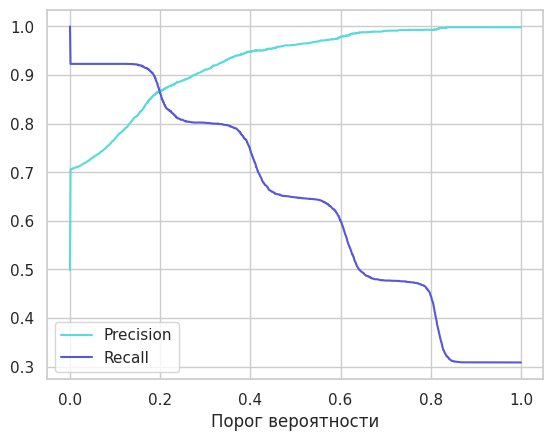

In [ ]:
plt.plot(thresholds, precision[:-1], label='Precision')
plt.xlabel('Порог вероятности')
plt.grid()


plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Порог вероятности')
plt.legend()
plt.grid()

In [ ]:
threshold = 0.2
pred_train_clf_knn = [1 if prob_preds_train_clf_knn[i][1]> threshold else 0 for i in range(len(prob_preds_train_clf_knn))]

In [ ]:
conf_matrix(y_train_smote, pred_train_clf_knn, clf_knn.classes_.astype(str))

In [ ]:
print(classification_report(y_train_smote, pred_train_clf_knn, labels = clf_knn.classes_))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7867
           1       1.00      1.00      1.00      7895

    accuracy                           1.00     15762
   macro avg       1.00      1.00      1.00     15762
weighted avg       1.00      1.00      1.00     15762



In [ ]:
probabilities_train_clf_knn = clf_knn.predict_proba(X_train_smote)[:,1]
fpr, tpr, th = roc_curve(y_train_smote, probabilities_train_clf_knn)

fig = px.area(x = fpr, y = tpr,
       labels = {
           'x':'False positive rate',
           'y': 'True positive rate'
                })
fig.add_trace(go.Scatter(x = [0,1], y=[0,1], marker_color = 'grey', showlegend = False))

In [ ]:
threshold = 0.2
pred_test_clf_knn = [1 if prob_preds_test_clf_knn[i][1]> threshold else 0 for i in range(len(prob_preds_test_clf_knn))]

In [ ]:
conf_matrix(y_test_smote, pred_test_clf_knn, clf_knn.classes_.astype(str))

In [ ]:
print(classification_report(y_test_smote, pred_test_clf_knn, labels = clf_knn.classes_))

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      3896
           1       0.87      0.86      0.86      3868

    accuracy                           0.87      7764
   macro avg       0.87      0.87      0.87      7764
weighted avg       0.87      0.87      0.87      7764



In [ ]:
probabilities_test_clf_knn = clf_knn.predict_proba(X_test_smote)[:,1]
fpr, tpr, th = roc_curve(y_test_smote, probabilities_test_clf_knn)

fig = px.area(x = fpr, y = tpr,
       labels = {
           'x':'False positive rate',
           'y': 'True positive rate'
                })
fig.add_trace(go.Scatter(x = [0,1], y=[0,1], marker_color = 'grey', showlegend = False))

## Сокращение размерности

### Модель 9. Соращение размерности (1 по лучшим ближайшим соседям)

In [ ]:
kf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)
knn = KNeighborsClassifier(n_neighbors = clf_knn.best_params_['classifier__n_neighbors'],
                           metric = clf_knn.best_params_['classifier__metric'],
                           weights =  clf_knn.best_params_['classifier__weights'])

nca = NeighborhoodComponentsAnalysis(n_components = 1)

pipeline = Pipeline(steps=[('nca', nca),
                           ('classifier', knn)])


In [ ]:
parameters = [{'nca__n_components': [3]}] #1, 2, 3

In [ ]:
clf_nca_1 = GridSearchCV(pipeline, parameters, cv = kf, verbose = 3, scoring = 'roc_auc')

In [ ]:
clf_nca_1.fit(X_train_smote, y_train_smote)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END ...............nca__n_components=3;, score=0.765 total time= 7.3min


KeyboardInterrupt: 

In [ ]:
clf_nca_1.best_params_

In [ ]:
clf_nca_1.best_score_

In [ ]:
pred_test_nca_1 = clf_nca_1.predict(X_test_smote)

In [ ]:
roc_auc_score(y_test_tl, clf_nca_1.predict_proba(X_test_smote)[:,1])

In [ ]:
clf_nca_1.score(X_test_smote, y_test_smote)

In [ ]:
accuracy_score(y_test_smote, pred_test_nca_1)

In [ ]:
conf_matrix(y_test_smote, pred_test_nca_1, clf_nca_1.classes_.astype(str))

In [ ]:
print(classification_report(y_test_smote, pred_test_nca_1, labels = clf_nca_1.classes_))

In [ ]:
probabilities_test = clf_nca_1.predict_proba(X_test_smote)[:,1]
fpr, tpr, th = roc_curve(y_test_smote, probabilities_test)

fig = px.area(x = fpr, y = tpr,
       labels = {
           'x':'False positive rate',
           'y': 'True positive rate'
                })
fig.add_trace(go.Scatter(x = [0,1], y=[0,1], marker_color = 'grey', showlegend = False))

In [ ]:
prob_preds_test = clf_nca_1.best_estimator_.predict_proba(X_test_smote)

In [ ]:
threshold = 0.8
pred_test_nca = [1 if prob_preds_test[i][1]> threshold else 0 for i in range(len(prob_preds_test))]

In [ ]:
conf_matrix(y_test_smote, pred_test_nca, clf_nca_1.classes_.astype(str))

# Сравнение моделей